> This script is TEMPORTAL. Holds steps 0.40 to 0.83 <br>
> Sources:
  
> Input file `data-regrouped-cpc-divisions-into-3-categories.xlsx` containing:
>  * Sheet1: Extended data with chosen LCIA methods, important metadata and PubChem properties
>  * METADATA: list of relevant metadata used in Sheet1.
>  * METHODS: list of LCIA methods used in Sheet1.

Note:
> `data-regrouped-cpc-divisions-into-3-categories.xlsx` file was generated in `0.31-vt-regroup-cpc-divisions-into-3-categories.ipynb`

In [1]:
# %env
# %who_ls
# %who
# %who int
# %pinfo <var name>

# Imports

In [1]:
%config IPCompleter.use_jedi = False # disable jedi autocompleter (https://stackoverflow.com/a/65734178/14485040)

import project_path  # makes possible the access to `src` directory using relative path
from src.data import (
    create_glo_market,
    filter_dataframe,
    internal_funcs,
    outlier_detectors,
)
from src.utils import explore_dir, make_readme_info
from src.utils import read_excel_to_pandas as r_excel
from src.utils import set_outputs_dir
from src.utils import write_pandas_to_excel as w_excel

%run init_nb.ipynb

# INPUTS: Identify file(s) and read data to df

In [2]:
# Explore the directory to find the file(s)
inputs_dir, files_list = explore_dir(
    path_to_dir=r"..\data\interim", file_extension="xlsx", print_files_list=True
)

['CPC33to36_other_chemicals.xlsx',
 'data-filtered-cpc-33to36-divisions.xlsx',
 'data-regrouped-cpc-divisions-into-3-categories.xlsx',
 'df_chemproperties.xlsx',
 'extended-data-chosen-methods-metadata-pubchem-properties.xlsx',
 'lcia-results-from-sp910-combined.xlsx',
 'list-chemicals-not-shown-on-fig-prices-vs-impacts.xlsx',
 'list-chemicals-not-shown-on-fig3.xlsx',
 'list-outliers.xlsx',
 'mapped-lcia-results.xlsx',
 'pubchem-properties.xlsx',
 'raw-data-chosen-lcia-methods-and-metadata.xlsx',
 'temp-df_base_full_wCAS.xlsx',
 'temp-df_base_full_wCAS_woOutliersRMDk9a5.xlsx',
 'temp-dict_fullMethods.xlsx',
 'to-check-regrouped-data-other-chemicals-category.xlsx']


In [6]:
# Read data
df_cpc33to36 = r_excel(
    inputs_dir, "data-regrouped-cpc-divisions-into-3-categories.xlsx"
)
print(
    "df_cpc33to36".ljust(40, "."),
    f"{df_cpc33to36.shape}\n".rjust(13, "."),
)

# Get list of LCIA methods and list of metadata
METHODS = r_excel(
    inputs_dir,
    "data-regrouped-cpc-divisions-into-3-categories.xlsx",
    sheets="METHODS",
    show_readme=False, 
)["METHODS"].values.tolist()

METADATA = r_excel(
    inputs_dir,
    "data-regrouped-cpc-divisions-into-3-categories.xlsx",
    sheets="METADATA",
    show_readme=False, 
)["METADATA"].values.tolist()


===> Trying to load 'readme' data... ===
File: data-regrouped-cpc-divisions-into-3-categories.xlsx from
C:\Users\ViteksPC\Documents\00-ETH_projects\17-AESA_ecoinvent_chemicals\notebooks\0.31-vt-regroup-cpc-divisions-into-3-categories.ipynb
Generated on 2021-07-30 (Friday), 18:09:25 by Tulus, V.
Includes:
<<<
Sheet1: Dataframe with chemicals from divisions 33-36 is regrouped into 3 categoreis: 'organic', 'inorganic' or 'other'.[New column 'category_regrouped' is added]
METADATA: list of relevant metadata used in Sheet1.
METHODS: list of LCIA methods used in Sheet1.
[METHODS + METADATA have to be the only column labels in Sheet1]
>>>

df_cpc33to36............................ ...(892, 39)



In [5]:
pd.options.display.max_columns = None

# Operations

## Create mass allocated GLO markets from non-GLO markets
<div class="alert alert-block alert-info">
created: <code>df_analysis_extended</code>
</div>

Created **df_analysis_extended** dataframe is of (1088, 39) shape.
category_regrouped
Organic chemical      543
Other chemical        278
Inorganic chemical    267
dtype: int64
Total:  1088

Shares in % for  category_regrouped
Inorganic chemical    24.54
Organic chemical      49.91
Other chemical        25.55
dtype: float64


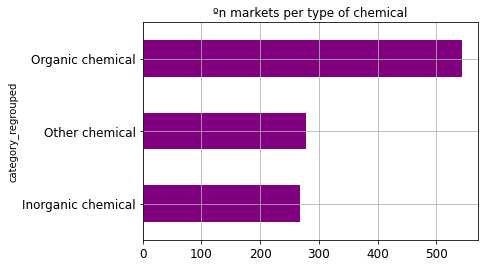

In [7]:
df_analysis_extended = create_glo_market(
    df_in=df_cpc33to36,
    columns_to_allocate=METHODS,
    activity_column="Activity",
    refprod_column="referenceProduct",
    geo_column="geo",
    prodvol_column="referenceProduct_prodVolume",
    comment_column="activity_generalComment",
)

print("Created **df_analysis_extended** dataframe is of {} shape.".format(df_analysis_extended.shape))
df_analysis_extended.tail(2)

internal_funcs.plot_categories(
    df_analysis_extended,
    groupby="category_regrouped",
    cutoff_value=0,
    color="purple",
    fontsize=12,
)

### Checks!

#### -- export to excel (activate if required)

In [20]:
# ## Export dataframe to excel
# excelName = "df_to_analyze_extended_GLOmarkets.xlsx"

# df_readme = readme_data(
#     excelName,
#     "Dataframe similar to df_to_analyze.xlsx [(selected) metadata of chemical markets and scores for multiple LCIA methods], but with additional GLO chemical markets, obtained from mass allocation of respective non-GLO markets.",
# )

# writedf_to_Excel(
#     path_to_file=outputsDir,
#     filename=excelName,
#     sheetname_and_data={"Sheet1": df_analysis_extended}, 
#     readme_data={"readme":df_readme},
# #     ExcelWriter_kwargs={"engine": "openpyxl", "encoding": "UTF-8"}
# #     startrow=0
# )

#### Checks

## Created dfs to work with: `df_base_full` and `df_base_full_wCAS`

#### create df_base only with GLO markets and individual FU=kg

Created **df_base** dataframe is of (668, 39) shape.

category_regrouped
Organic chemical      320
Other chemical        183
Inorganic chemical    165
dtype: int64
Total:  668

Shares in % for  category_regrouped
Inorganic chemical    24.7
Organic chemical      47.9
Other chemical        27.4
dtype: float64


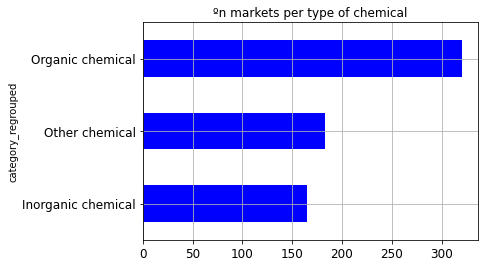

In [21]:
df_base = df_analysis_extended[
    (df_analysis_extended.geo == "GLO")
    & (df_analysis_extended.referenceProductUnit == "kg")
]# .shape


# # Group by shortName_geo_SP -> filter by GLO -> Filter "unit" by "kg"
# df_base = _filter_by_geo_and_FU(
# #     df=df_analysis,
#     df=df_analysis_extended,
#     geo="GLO", 
#     FU="kg"
# )
print("Created **df_base** dataframe is of {} shape.\n".format(df_base.shape))
# df_base

# Grouping by 'category' and ploting the size of each group on a barh plot (in one line)
internal_funcs.plot_categories(
    df_in=df_base,
    groupby="category_regrouped",   
    color="blue", 
    fontsize=12,
    cutoff_value=8,
)

In [22]:
# Products excluded from the analysis
internal_funcs.excluded_products(
    df_raw=df_analysis_extended, # or =df_analysis_extended, (both have the same nº of unique products)
    df_filtered=df_base
)

676 unique reference products in df_raw
668 unique reference products in df_filtered
-------------------------
8 not included products
(because they don't satisfy the filtering criteria): 



,geo,unit
product,,
"Green manure, organic, until February",CH,ha
"Green manure, Swiss integrated production, until April",GLO,ha
"Green manure, Swiss integrated production, until February",GLO,ha
"Green manure, Swiss integrated production, until January",GLO,ha
"Green manure, Swiss integrated production, until March",GLO,ha
"Green manure, organic, until April",GLO,ha
"Green manure, organic, until January",GLO,ha
"Green manure, organic, until March",GLO,ha


#### add transgression levels (TLs) to df_base
<div class="alert alert-block alert-warning">
created: <strong>df_base_full and df_base_full_wCAS</strong>  
</div> 

In [23]:
# correct methods name for TLs... add lst_methods_TLs
lst_methods_TLs = lst_methods_TLs = ["TL in " + sub for sub in lst_methods[1:]]
lst_methods_TLs

["TL in ('PBs-LCIA (baseline) V0.72', 'Climate change - CO2 concentration', 'ppm')",
 "TL in ('PBs-LCIA (baseline) V0.72', 'Climate change - Energy imbalance', 'Wm-2')",
 "TL in ('PBs-LCIA (baseline) V0.72', 'Stratospheric ozone depletion', 'DU')",
 "TL in ('PBs-LCIA (baseline) V0.72', 'Ocean acidification', 'Omega Aragon')",
 "TL in ('PBs-LCIA (baseline) V0.72', 'Biogeochemical flows - P', 'Tg P')",
 "TL in ('PBs-LCIA (baseline) V0.72', 'Biogeochemical flows - N', 'Tg N')",
 "TL in ('PBs-LCIA (baseline) V0.72', 'Land-system change - Global', '%')",
 "TL in ('PBs-LCIA (baseline) V0.72', 'Freshwater use - Global', 'km3')",
 "TL in ('PBs-LCIA (baseline) V0.72', 'Change in biosphere integrity - BII loss', '% BII loss')"]

##### create `df_base_full` with ALL activities

In [24]:
df_base_full = pd.concat(
    [
        df_base,
        calculate_TL_PBs(
            df_base,
            method_labels=lst_methods[1:],
            price_column="referenceProduct_price",
            GVA_world = 7.38e13, # in 2018
            correctGVA=None,
#             correctGVA="sales",
#             correctGVA="purchases",
#             share_of_SOS=0.0689, # aggregated shares of 4 sectors (C19-22) using GGG method
#             share_of_SOS=0.0237, # only C20 sector using GGG method
#             share_of_SOS=0.0274, # aggregated shares of 4 sectors (C19-22) using WIOD with L inverse
#             share_of_SOS=0.0076, # only C20 sector using WIOD with L inverse
        ).add_prefix("TL in "),
    ],
    axis=1,
)
print("Created **df_base_full** dataframe is of {} shape.\n".format(df_base_full.shape))
df_base_full.tail(5)

Created **df_base_full** dataframe is of (668, 48) shape.



,Activity,category_regrouped,activity_comment,type,referenceProduct,category,inline_comment,geo,activity_ISICclass,activity_ecoSpold01class,technologyLevel,referenceProductAmount,referenceProductUnit,referenceProduct_prodVolume,referenceProduct_prodVolumeComment,referenceProduct_price,referenceProduct_priceUnit,referenceProduct_priceComment,referenceProduct_casNumber,referenceProduct_CPCclass,activity_generalComment,sourceFilename,pubchem_match,num_matches,MF,MW,iupac,complexity,synonyms,"('IPCC 2013 GWP 100a V1.03', 'IPCC GWP 100a', 'kg CO2 eq')","('PBs-LCIA (baseline) V0.72', 'Climate change - CO2 concentration', 'ppm')","('PBs-LCIA (baseline) V0.72', 'Climate change - Energy imbalance', 'Wm-2')","('PBs-LCIA (baseline) V0.72', 'Stratospheric ozone depletion', 'DU')","('PBs-LCIA (baseline) V0.72', 'Ocean acidification', 'Omega Aragon')","('PBs-LCIA (baseline) V0.72', 'Biogeochemical flows - P', 'Tg P')","('PBs-LCIA (baseline) V0.72', 'Biogeochemical flows - N', 'Tg N')","('PBs-LCIA (baseline) V0.72', 'Land-system change - Global', '%')","('PBs-LCIA (baseline) V0.72', 'Freshwater use - Global', 'km3')","('PBs-LCIA (baseline) V0.72', 'Change in biosphere integrity - BII loss', '% BII loss')","TL in ('PBs-LCIA (baseline) V0.72', 'Climate change - CO2 concentration', 'ppm')","TL in ('PBs-LCIA (baseline) V0.72', 'Climate change - Energy imbalance', 'Wm-2')","TL in ('PBs-LCIA (baseline) V0.72', 'Stratospheric ozone depletion', 'DU')","TL in ('PBs-LCIA (baseline) V0.72', 'Ocean acidification', 'Omega Aragon')","TL in ('PBs-LCIA (baseline) V0.72', 'Biogeochemical flows - P', 'Tg P')","TL in ('PBs-LCIA (baseline) V0.72', 'Biogeochemical flows - N', 'Tg N')","TL in ('PBs-LCIA (baseline) V0.72', 'Land-system change - Global', '%')","TL in ('PBs-LCIA (baseline) V0.72', 'Freshwater use - Global', 'km3')","TL in ('PBs-LCIA (baseline) V0.72', 'Change in biosphere integrity - BII loss', '% BII loss')"
1083,"Zinc monosulfate, combined to GLO market",Inorganic chemical,None,Products,Zinc monosulfate,Chemicals\Inorganic\Market,None,GLO,2011:Manufacture of basic chemicals,NaN,NaN,1,kg,5.747126e+06,None,0.471,EUR2005,None,NaN,34220: Zinc oxide; zinc peroxide; chromium oxi...,"Combined activity, mass allocated from RER, Ro...",None,No match,0,NaN,NaN,NaN,NaN,NaN,0.751138,1.852816e-11,2.483952e-13,3.753353e-15,5.661723e-14,7.191653e-16,1.217872e-13,2.080040e-16,1.853705e-12,1.862367e-13,28.095109,27.119029,0.028261,8.958401,0.007931,0.214457,0.000908,0.050595,2.033276
1084,"Diethyl ether, without water, in 99.95% soluti...",Organic chemical,None,Products,"Diethyl ether, without water, in 99.95% soluti...",Chemicals\Organic\Market,None,GLO,2011:Manufacture of basic chemicals,NaN,NaN,1,kg,1.889956e+07,None,1.120,EUR2005,None,60-29-7,"34170: Ethers, alcohol peroxides, ether peroxi...","Combined activity, mass allocated from RoW loc...",None,by CAS,1,C4H10O,74.120,ethoxyethane,11.1,"['DIETHYL ETHER', 'ether', 'Ethyl ether', 'Eth...",5.560823,1.312176e-10,1.771425e-12,2.863007e-14,4.009664e-13,6.437446e-13,1.978399e-12,6.452035e-16,1.110460e-11,1.312028e-12,83.674532,81.331096,0.090654,26.680425,2.985467,1.465062,0.001185,0.127461,6.023887
1085,"Silicon tetrachloride, combined to GLO market",Inorganic chemical,None,Products,Silicon tetrachloride,Chemicals\Inorganic\Market,None,GLO,2011:Manufacture of basic chemicals,NaN,NaN,1,kg,3.764650e+08,None,13.800,EUR2005,None,10026-04-7,342: Basic inorganic chemicals n.e.c.,"Combined activity, mass allocated from RoW loc...",None,by CAS,1,Cl4Si,169.900,tetrachlorosilane,19.1,"['Tetrachlorosilane', 'SILICON TETRACHLORIDE',...",2.976041,7.383021e-11,9.901631e-13,1.842824e-14,2.256061e-13,2.480280e-15,7.372767e-13,6.609219e-16,6.604953e-12,7.119144e-13,3.820977,3.689602,0.004736,1.218357,0.000934,0.044311,0.000099,0.006153,0.265278
1086,"Sodium formate, combined to GLO market",Organic chemical,None,Products,Sodium formate,Chemicals\Organic\Market,None,GLO,2011:Manufacture of basic chemicals,NaN,0.0,1,kg,3.572024e+09

In [25]:
# convert prices from EUR2005 to USD2018
# using this unit the TLs were calculated !!!
PPI_2018 = 104.5 # Producer Price Index from Eurostat
PPI_2005 = 86.0  # Producer Price Index from Eurostat
USD_per_EUR_2018 = 1.1811 # average exchange rate EUR to USD in 2018

df_base_full.referenceProduct_price = (df_base_full.referenceProduct_price * PPI_2018 / PPI_2005) * USD_per_EUR_2018
df_base_full.referenceProduct_priceUnit = "USD2018"
df_base_full.sample(2)

,Activity,category_regrouped,activity_comment,type,referenceProduct,category,inline_comment,geo,activity_ISICclass,activity_ecoSpold01class,technologyLevel,referenceProductAmount,referenceProductUnit,referenceProduct_prodVolume,referenceProduct_prodVolumeComment,referenceProduct_price,referenceProduct_priceUnit,referenceProduct_priceComment,referenceProduct_casNumber,referenceProduct_CPCclass,activity_generalComment,sourceFilename,pubchem_match,num_matches,MF,MW,iupac,complexity,synonyms,"('IPCC 2013 GWP 100a V1.03', 'IPCC GWP 100a', 'kg CO2 eq')","('PBs-LCIA (baseline) V0.72', 'Climate change - CO2 concentration', 'ppm')","('PBs-LCIA (baseline) V0.72', 'Climate change - Energy imbalance', 'Wm-2')","('PBs-LCIA (baseline) V0.72', 'Stratospheric ozone depletion', 'DU')","('PBs-LCIA (baseline) V0.72', 'Ocean acidification', 'Omega Aragon')","('PBs-LCIA (baseline) V0.72', 'Biogeochemical flows - P', 'Tg P')","('PBs-LCIA (baseline) V0.72', 'Biogeochemical flows - N', 'Tg N')","('PBs-LCIA (baseline) V0.72', 'Land-system change - Global', '%')","('PBs-LCIA (baseline) V0.72', 'Freshwater use - Global', 'km3')","('PBs-LCIA (baseline) V0.72', 'Change in biosphere integrity - BII loss', '% BII loss')","TL in ('PBs-LCIA (baseline) V0.72', 'Climate change - CO2 concentration', 'ppm')","TL in ('PBs-LCIA (baseline) V0.72', 'Climate change - Energy imbalance', 'Wm-2')","TL in ('PBs-LCIA (baseline) V0.72', 'Stratospheric ozone depletion', 'DU')","TL in ('PBs-LCIA (baseline) V0.72', 'Ocean acidification', 'Omega Aragon')","TL in ('PBs-LCIA (baseline) V0.72', 'Biogeochemical flows - P', 'Tg P')","TL in ('PBs-LCIA (baseline) V0.72', 'Biogeochemical flows - N', 'Tg N')","TL in ('PBs-LCIA (baseline) V0.72', 'Land-system change - Global', '%')","TL in ('PBs-LCIA (baseline) V0.72', 'Freshwater use - Global', 'km3')","TL in ('PBs-LCIA (baseline) V0.72', 'Change in biosphere integrity - BII loss', '% BII loss')"
881,"Zinc oxide {GLO}| market for | APOS, S",Inorganic chemical,Production volume: 300000000 kgIncluded act...,Products,Zinc oxide,Chemicals\Inorganic\Market,Production Volume Amount: 300000000,GLO,2011:Manufacture of basic chemicals,chemicals/inorganics,0.0,1,kg,300000000.0,NaN,2.870348,USD2018,Estimated based on expert judgement and knowle...,NaN,34220: Zinc oxide; zinc peroxide; chromium oxi...,NaN,23766_d272b08a-d655-416c-bb18-862a2c0233e0_77a...,by NAME,1,OZn,81.40,oxozinc,2.0,"['ZINC OXIDE', '1314-13-2', 'oxozinc', 'Zinc W...",0.846993,2.102089e-11,2.827808e-13,3.954110e-15,6.423442e-14,5.799395e-16,1.027167e-13,1.618692e-16,1.866169e-12,2.026131e-13,7.506552,7.270626,0.007011,2.393539,0.001506,0.042596,0.000166,0.011995,0.520942
1039,"Polyurethane, rigid foam, combined to GLO market",Organic chemical,None,Products,"Polyurethane, rigid foam",Plastics\Thermosets\Market,None,GLO,2013:Manufacture of plastics and synthetic rub...,NaN,NaN,1,kg,4.0,None,1.851374,USD2018,None,9009-54-5,"34740: Polyacetals, other polyethers and epoxi...","Combined activity, mass allocated from RER, Ro...",None,by CAS,1,C3H8N2O,88.11,ethylurea,52.8,"['Ethylurea', '625-52-5', '1-Ethylurea', 'N-ET...",6.476255,1.337976e-10,1.933060e-12,4.339303e-13,4.088456e-13,1.454457e-13,1.864270e-11,7.663262e-16,2.707067e-11,1.507172e-12,74.076086,77.056173,1.192928,23.619590,0.585636,11.986140,0.001222,0.269775,6.007931


category_regrouped
Organic chemical      320
Other chemical        183
Inorganic chemical    165
dtype: int64
Total:  668

Shares in % for  category_regrouped
Inorganic chemical    24.7
Organic chemical      47.9
Other chemical        27.4
dtype: float64


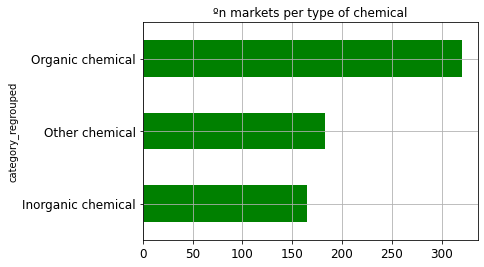

In [26]:
# Grouping by 'category_regrouped' and ploting the size of each group on a barh plot (in one line)
internal_funcs.plot_categories(
    df_in=df_base_full,
    groupby="category_regrouped",
    color="green",
    fontsize=12,
)

In [27]:
df_base_full[df_base_full.referenceProduct == 'Cyclic N-compound']

,Activity,category_regrouped,activity_comment,type,referenceProduct,category,inline_comment,geo,activity_ISICclass,activity_ecoSpold01class,technologyLevel,referenceProductAmount,referenceProductUnit,referenceProduct_prodVolume,referenceProduct_prodVolumeComment,referenceProduct_price,referenceProduct_priceUnit,referenceProduct_priceComment,referenceProduct_casNumber,referenceProduct_CPCclass,activity_generalComment,sourceFilename,pubchem_match,num_matches,MF,MW,iupac,complexity,synonyms,"('IPCC 2013 GWP 100a V1.03', 'IPCC GWP 100a', 'kg CO2 eq')","('PBs-LCIA (baseline) V0.72', 'Climate change - CO2 concentration', 'ppm')","('PBs-LCIA (baseline) V0.72', 'Climate change - Energy imbalance', 'Wm-2')","('PBs-LCIA (baseline) V0.72', 'Stratospheric ozone depletion', 'DU')","('PBs-LCIA (baseline) V0.72', 'Ocean acidification', 'Omega Aragon')","('PBs-LCIA (baseline) V0.72', 'Biogeochemical flows - P', 'Tg P')","('PBs-LCIA (baseline) V0.72', 'Biogeochemical flows - N', 'Tg N')","('PBs-LCIA (baseline) V0.72', 'Land-system change - Global', '%')","('PBs-LCIA (baseline) V0.72', 'Freshwater use - Global', 'km3')","('PBs-LCIA (baseline) V0.72', 'Change in biosphere integrity - BII loss', '% BII loss')","TL in ('PBs-LCIA (baseline) V0.72', 'Climate change - CO2 concentration', 'ppm')","TL in ('PBs-LCIA (baseline) V0.72', 'Climate change - Energy imbalance', 'Wm-2')","TL in ('PBs-LCIA (baseline) V0.72', 'Stratospheric ozone depletion', 'DU')","TL in ('PBs-LCIA (baseline) V0.72', 'Ocean acidification', 'Omega Aragon')","TL in ('PBs-LCIA (baseline) V0.72', 'Biogeochemical flows - P', 'Tg P')","TL in ('PBs-LCIA (baseline) V0.72', 'Biogeochemical flows - N', 'Tg N')","TL in ('PBs-LCIA (baseline) V0.72', 'Land-system change - Global', '%')","TL in ('PBs-LCIA (baseline) V0.72', 'Freshwater use - Global', 'km3')","TL in ('PBs-LCIA (baseline) V0.72', 'Change in biosphere integrity - BII loss', '% BII loss')"
348,"Cyclic N-compound {GLO}| market for | APOS, S",Other chemical,"In this market, expert judgement was used to d...",Products,Cyclic N-compound,Chemicals\Pesticides\Market,Production Volume Amount: 7089427.6424581,GLO,2021:Manufacture of pesticides and other agroc...,agricultural means of production/pesticides,0.0,1,kg,7.089428e+06,NaN,8.223546,USD2018,Calculated based on inputs: The price of the p...,NaN,"3466: Insecticides, fungicides, herbicides and...","In this market, expert judgement was used to d...",21056_7f9fbb48-a135-4010-849c-4ad695d3ad62_d00...,No match,0,NaN,NaN,NaN,NaN,NaN,15.364283,3.584423e-10,4.939219e-12,4.429804e-13,1.095305e-12,2.815296e-12,4.051603e-12,2.112249e-15,2.706912e-11,3.686014e-12,44.677001,44.325694,0.274166,14.245685,2.552032,0.586452,0.000758,0.060731,3.307914


In [28]:
# ## Export dataframe to excel
# excelName = "df_base_full.xlsx"

# df_readme = readme_data(
#     excelName,
#     "Dataframe df_base_full - all GLO markets with PBs and TLs.",
# )

# writedf_to_Excel(
#     path_to_file=outputsDir,
#     filename=excelName,
#     sheetname_and_data={"Sheet1": df_base_full}, 
#     readme_data={"readme":df_readme},
# #     ExcelWriter_kwargs={"engine": "openpyxl", "encoding": "UTF-8"}
# #     startrow=0
# )

##### create `df_base_full_wCAS` ONLY with activities detected in PubChem

In [29]:
df_base_full_wCAS = df_base_full[df_base_full.num_matches != 0]

print("Created **df_base_full_wCAS** dataframe is of {} shape.\n".format(df_base_full_wCAS.shape))
df_base_full_wCAS.sample(2)

Created **df_base_full_wCAS** dataframe is of (492, 48) shape.



,Activity,category_regrouped,activity_comment,type,referenceProduct,category,inline_comment,geo,activity_ISICclass,activity_ecoSpold01class,technologyLevel,referenceProductAmount,referenceProductUnit,referenceProduct_prodVolume,referenceProduct_prodVolumeComment,referenceProduct_price,referenceProduct_priceUnit,referenceProduct_priceComment,referenceProduct_casNumber,referenceProduct_CPCclass,activity_generalComment,sourceFilename,pubchem_match,num_matches,MF,MW,iupac,complexity,synonyms,"('IPCC 2013 GWP 100a V1.03', 'IPCC GWP 100a', 'kg CO2 eq')","('PBs-LCIA (baseline) V0.72', 'Climate change - CO2 concentration', 'ppm')","('PBs-LCIA (baseline) V0.72', 'Climate change - Energy imbalance', 'Wm-2')","('PBs-LCIA (baseline) V0.72', 'Stratospheric ozone depletion', 'DU')","('PBs-LCIA (baseline) V0.72', 'Ocean acidification', 'Omega Aragon')","('PBs-LCIA (baseline) V0.72', 'Biogeochemical flows - P', 'Tg P')","('PBs-LCIA (baseline) V0.72', 'Biogeochemical flows - N', 'Tg N')","('PBs-LCIA (baseline) V0.72', 'Land-system change - Global', '%')","('PBs-LCIA (baseline) V0.72', 'Freshwater use - Global', 'km3')","('PBs-LCIA (baseline) V0.72', 'Change in biosphere integrity - BII loss', '% BII loss')","TL in ('PBs-LCIA (baseline) V0.72', 'Climate change - CO2 concentration', 'ppm')","TL in ('PBs-LCIA (baseline) V0.72', 'Climate change - Energy imbalance', 'Wm-2')","TL in ('PBs-LCIA (baseline) V0.72', 'Stratospheric ozone depletion', 'DU')","TL in ('PBs-LCIA (baseline) V0.72', 'Ocean acidification', 'Omega Aragon')","TL in ('PBs-LCIA (baseline) V0.72', 'Biogeochemical flows - P', 'Tg P')","TL in ('PBs-LCIA (baseline) V0.72', 'Biogeochemical flows - N', 'Tg N')","TL in ('PBs-LCIA (baseline) V0.72', 'Land-system change - Global', '%')","TL in ('PBs-LCIA (baseline) V0.72', 'Freshwater use - Global', 'km3')","TL in ('PBs-LCIA (baseline) V0.72', 'Change in biosphere integrity - BII loss', '% BII loss')"
972,"Dimethyl sulfate, combined to GLO market",Other chemical,None,Products,Dimethyl sulfate,Chemicals\Organic\Market,None,GLO,2011:Manufacture of basic chemicals,NaN,NaN,1,kg,4.000000e+00,None,0.985964,USD2018,None,77-78-1,34: Basic chemicals,"Combined activity, mass allocated from RER, Ro...",None,by CAS,1,C2H6O4S,126.13,dimethyl sulfate,107.0,"['DIMETHYL SULFATE', '77-78-1', 'Dimethyl sulp...",1.292571,3.008774e-11,4.079846e-13,6.753935e-15,9.194013e-14,9.144748e-16,1.701985e-13,4.117298e-16,3.511756e-12,3.160799e-13,31.278956,30.537883,0.034865,9.973582,0.006914,0.205475,0.001233,0.065714,2.365876
212,"Alkylbenzene sulfonate, linear, petrochemical ...",Organic chemical,"In this market, expert judgement was used to d...",Products,"Alkylbenzene sulfonate, linear, petrochemical",Chemicals\Washing agents\Tensides\Market,Production Volume Amount: 2600000000,GLO,"2023:Manufacture of soap and detergents, clean...",washing agents/tensides,0.0,1,kg,2.600000e+09,NaN,1.155315,USD2018,Calculated based on inputs: The price of the p...,42615-29-2,341: Basic organic chemicals,"In this market, expert judgement was used to d...",20655_81dbc6ca-3b24-46dc-8a44-1dc489a71cde_290...,by CAS,1,C18H29NaO3S,348.50,sodium;4-dodecan-2-ylbenzenesulfonate,370.0,"['Sodium (1-methylundecyl)benzenesulfonate', '...",1.710051,4.073507e-11,5.440720e-13,5.727820e-15,1.244756e-13,1.578902e-15,2.535875e-13,2.174038e-16,2.565671e-12,4.159152e-13,36.140313,34.754604,0.025233,11.523674,0.010188,0.261272,0.000555,0.040973,2.656812


category_regrouped
Organic chemical      262
Inorganic chemical    151
Other chemical         79
dtype: int64
Total:  492

Shares in % for  category_regrouped
Inorganic chemical    30.69
Organic chemical      53.25
Other chemical        16.06
dtype: float64


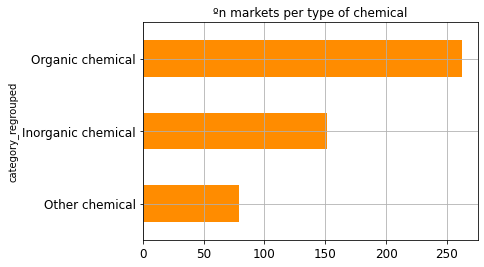

In [30]:
# Grouping by 'category_regrouped' and ploting the size of each group on a barh plot (in one line)
internal_funcs.plot_categories(
    df_in=df_base_full_wCAS,
    groupby="category_regrouped",
    color="darkorange",
    fontsize=12,
)

## `highlighted_product` list

### research possible highlighted products

In [31]:
lst_known_chemicals = [
    "Toluene",
    "Xylene",
    # Javier's list below
    "Liquefied petroleum gas",  # ok
    "Petrol",  # "Gasoline", # ok
    "Diesel",  # ok
    "Kerosene",  # ok
    "Ethylene",  # ok
    "Propylene",  # ok
    "Benzene",  # ok
    "Synthetic gas",  # FU 1m3
    "Ammonia, liquid",  # ok
    "Methanol",  # ok
    "Sulfuric acid",  # ok
    "Chlorine",  # ok
    "Acetic acid",  # ok
    "Formaldehyde",  # ok
    "Urea",  # ok
    "Ethylene oxide",  # ok
    "Acrylonitrile",  # ok
    "Acetaldehyde",  # ok
    "Polyethylene",  # ok
    "Polypropylene",  # ok
    "Polyvinylchloride",  # ok
    "Hydrogen",  # ok
]

for item in lst_known_chemicals:
    print("Looking for " + item)
    filter_dataframe(
        df_analysis_extended,
        col_name="referenceProduct",
        filter_in=[item],
        print_unique=True,
    )

Looking for Toluene
List of unique items matching your request:
		 ['Toluene diisocyanate', 'Toluene, liquid'] 

Looking for Xylene
List of unique items matching your request:
		 ['Xylene'] 

Looking for Liquefied petroleum gas
List of unique items matching your request:
		 ['Liquefied petroleum gas'] 

Looking for Petrol
List of unique items matching your request:
		 ['Petrol, 15% ETBE additive by volume, with ethanol from biomass', 'Petrol, 5% ethanol by volume from biomass', 'Petrol, unleaded', 'Petrol, 4% ETBE additive by volume, with ethanol from biomass', 'Petroleum coke', 'Petrol, low-sulfur', 'Petrol, two-stroke blend'] 

Looking for Diesel
List of unique items matching your request:
		 ['Diesel, low-sulfur', 'Diesel'] 

Looking for Kerosene
List of unique items matching your request:
		 ['Kerosene'] 

Looking for Ethylene
List of unique items matching your request:
		 ['Ethylene carbonate', 'Ethylene vinyl acetate copolymer', 'Ethylene glycol monoethyl ether', 'Ethylene glycol

### selected products

In [32]:
# Exact names only!

highlighted_product = [
    "Sulfuric acid",
    "Kerosene",
    "Diesel, low-sulfur", # or "Diesel",
    "Liquefied petroleum gas",
    "Methanol",
    "Petrol, low-sulfur",
    "Formaldehyde",
    "Chlorine, liquid",
    "Ethylene, average",
    "Propylene",
    "Toluene, liquid",
    "Acetic acid, without water, in 98% solution state",
    "Acetaldehyde",
    "Polyethylene, high density, granulate",
    "Benzene",
    "Ammonia, liquid",
    "Polypropylene, granulate",
    "Ethylene oxide",
    "Polyvinylchloride, bulk polymerised",
    "Hydrogen, liquid",
    "Acrylonitrile",
    "Urea, as N",
    "1-propanol",
    "Acetylene",
    "Chlorotoluron",
    "Methylene diphenyl diisocyanate",
    "Ammonium nitrate, as N",
    "Pyridine",
    "Nylon 6-6",
    "Glyphosate",
    "Para-phenylene diamine",
    "Fluorine, liquid",
    "Adipic acid",
    "Xylene"
]

selected = internal_funcs.find_chemicals(
    df_base_full,
#     df_base_full_wCAS,
    highlighted_product,
    colname="referenceProduct",
)[
    ["Activity"]
    + ["referenceProduct"]
    + ["geo"]
    #     + ["category"]
        + ["category_regrouped"]
    + ["referenceProduct_CPCclass"]
    #     + ["referenceProduct_prodVolume"]
    + ["('IPCC 2013 GWP 100a V1.03', 'IPCC GWP 100a', 'kg CO2 eq')"]
    #     + ["complexity"]
        + ["MF"]
    #     lst_metadata
    #     + lst_methods
]

selected[selected.geo == "GLO"].sort_values(
    by="('IPCC 2013 GWP 100a V1.03', 'IPCC GWP 100a', 'kg CO2 eq')"
)

,Activity,referenceProduct,geo,category_regrouped,referenceProduct_CPCclass,"('IPCC 2013 GWP 100a V1.03', 'IPCC GWP 100a', 'kg CO2 eq')",MF
1069,"Sulfuric acid, combined to GLO market",Sulfuric acid,GLO,Inorganic chemical,34231: Chemical elements n.e.c.; inorganic aci...,0.150888,H2O4S
918,"Kerosene, combined to GLO market",Kerosene,GLO,Organic chemical,3334: Kerosenes,0.534435,NaN
914,"Diesel, low-sulfur, combined to GLO market","Diesel, low-sulfur",GLO,Organic chemical,33360: Gas oil,0.556683,NaN
920,"Liquefied petroleum gas, combined to GLO market",Liquefied petroleum gas,GLO,Organic chemical,334: Petroleum gases and other gaseous hydroca...,0.666843,NaN
534,"Methanol {GLO}| market for | APOS, S",Methanol,GLO,Organic chemical,"34139: Other alcohols, phenols, phenol-alcohol...",0.671405,CH4O
923,"Petrol, low-sulfur, combined to GLO market","Petrol, low-sulfur",GLO,Organic chemical,333: Petroleum oils and oils obtained from bit...,0.804746,NaN
988,"Formaldehyde, combined to GLO market",Formaldehyde,GLO,Organic chemical,"34170: Ethers, alcohol peroxides, ether peroxi...",0.991961,CH2O
961,"Chlorine, liquid, combined to GLO market","Chlorine, liquid",GLO,Inorganic chemical,34231: Chemical elements n.e.c.; inorganic aci...,1.015311,Cl2
915,"Ethylene, average, combined to GLO market","Ethylene, average",GLO,Organic chemical,"33421: Ethylene, propylene, butylene, butadiene",1.455164,C2H4
925,"Propylene, combined to GLO market",Propylene,GLO,Organic chemical,"33421: Ethylene, propylene, butylene, butadiene",1.498340,C3H6


In [33]:
# Make df of highlighted_product for later export
df_highlighted_product = pd.DataFrame(highlighted_product, columns=["highlighted_product"])
# df_highlighted_product

### -- export to excel (activate if required)

In [34]:
# ## Export dataframe to excel
# excelName = "df_GLO_markets.xlsx"

# df_readme = readme_data(
#     excelName,
#     "Filtered dataframe includes only GLO chemical markets with FU = 1kg",
# )

# writedf_to_Excel(
#     path_to_file=outputsDir,
#     filename=excelName,
#     sheetname_and_data={"Sheet1": df_base}, 
#     readme_data={"readme":df_readme},
# #     ExcelWriter_kwargs={"engine": "openpyxl", "encoding": "UTF-8"}
# #     startrow=0
# )

## Filtering outliers
<div class="alert alert-block alert-info">
use previously created:  <br>
    <strong>df_base_full</strong> - only GLO, kg markets from CPC 33-36  <br>
    <strong>ddf_base_full_wCAS</strong> - only GLO, kg markets from CPC 33-36 with identified chemical properties (could be refined!)
</div>

### apply Mahalanobis Distance method to detect outliers

In [35]:
# df_to_detect_MDm = df_base_full
df_to_detect_MDm = df_base_full_wCAS

(
    df_clean_metNtlNpr_MDm,
    df_outliers_metNtlNpr_MDm,
    more_metNtlNpr_MDm,
) = outlier_detectors.mahalanobis_method(
    df_raw=df_to_detect_MDm[
        lst_methods[0:1]
        + lst_methods[1:]
        + lst_methods_TLs
        + ["referenceProduct_price"]
    ],
    alpha=(1 - 0.95),
)
print("out of", df_to_detect_MDm.shape[0], "items")
print(len(more_metNtlNpr_MDm[0]), "outliers detected")

outlier_detectors.make_full_df_after_outlier_detection_method(
    df_to_detect_MDm, df_outliers_metNtlNpr_MDm
)[
    ["referenceProduct"]
    + [lst_methods[0]]
    + [lst_methods_TLs[0]]
    + ["referenceProduct_price"]
]

out of 492 items
44 outliers detected


,referenceProduct,"('IPCC 2013 GWP 100a V1.03', 'IPCC GWP 100a', 'kg CO2 eq')","TL in ('PBs-LCIA (baseline) V0.72', 'Climate change - CO2 concentration', 'ppm')",referenceProduct_price
40,"Ethanol, without water, in 95% solution state,...",0.882455,47.335480,0.464996
41,"Ethanol, without water, in 99.7% solution stat...",1.708591,75.484285,0.625736
59,Magnetite,0.982376,548.048950,0.045639
77,Pyrazole,17.952560,74.401817,4.850888
160,"Uranium, enriched 3.0%, in fuel element for li...",2528.017400,69.804762,841.011869
161,"Uranium, enriched 3.8%, in fuel element for li...",3460.664000,95.146528,841.011869
162,"Uranium, enriched 3.9%, in fuel element for li...",3558.290300,97.812362,841.011869
163,"Uranium, enriched 4%, in fuel element for ligh...",3669.221300,100.803808,841.011869
164,"Uranium, enriched 4.2%, in fuel element for li...",3907.162200,107.278840,841.011869
211,Adipic acid,13.733554,77.620220,1.549988


In [36]:
# df_base_full_wCAS[
#     df_base_full_wCAS["('IPCC 2013 GWP 100a V1.03', 'IPCC GWP 100a', 'kg CO2 eq')"]
#     > 1000
# ]

category_regrouped
Organic chemical      248
Inorganic chemical    137
Other chemical         63
dtype: int64
Total:  448

Shares in % for  category_regrouped
Inorganic chemical    30.58
Organic chemical      55.36
Other chemical        14.06
dtype: float64


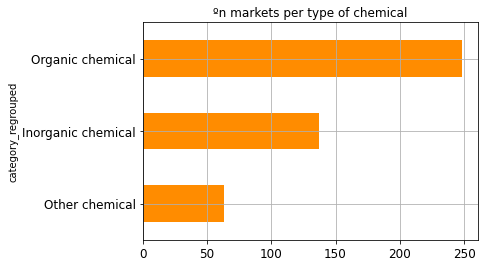

In [37]:
# Grouping by 'category_regrouped' and ploting the size of each group on a barh plot (in one line)

df_base_full_wCAS_woOutliersMDk20a5 = outlier_detectors.make_full_df_after_outlier_detection_method(
    df_to_detect_MDm, df_clean_metNtlNpr_MDm
)

internal_funcs.plot_categories(
    df_in=df_base_full_wCAS_woOutliersMDk20a5,
    groupby="category_regrouped",
    color="darkorange",
    fontsize=12,
)

### apply Robust Mahalanobis Distance method to detect outliers

In [38]:
# df_to_detect_RMDm = df_base_full
df_to_detect_RMDm = df_base_full_wCAS

(
    df_clean_metNtlNpr_RMDm,
    df_outliers_metNtlNpr_RMDm,
    more_metNtlNpr_RMDm,
) = outlier_detectors.robust_mahalanobis_method(
    df_to_detect_RMDm[
        #         lst_methods
        #         +
        lst_methods_TLs
        #         + ["referenceProduct_price"]
    ],
    alpha=(1 - 0.95),
    support_fraction=None,
)
print("out of", df_to_detect_RMDm.shape[0], "items")
print(len(more_metNtlNpr_RMDm[0]), "outliers detected")

outlier_detectors.make_full_df_after_outlier_detection_method(
    df_to_detect_RMDm, df_outliers_metNtlNpr_RMDm
)[
    ["referenceProduct"]
    + [lst_methods[0]]
    + [lst_methods_TLs[0]]
    + ["referenceProduct_price"]
]

out of 492 items
26 outliers detected


,referenceProduct,"('IPCC 2013 GWP 100a V1.03', 'IPCC GWP 100a', 'kg CO2 eq')","TL in ('PBs-LCIA (baseline) V0.72', 'Climate change - CO2 concentration', 'ppm')",referenceProduct_price
40,"Ethanol, without water, in 95% solution state,...",0.882455,47.335480,0.464996
41,"Ethanol, without water, in 99.7% solution stat...",1.708591,75.484285,0.625736
59,Magnetite,0.982376,548.048950,0.045639
211,Adipic acid,13.733554,77.620220,1.549988
235,"Ammonium nitrate, as N",7.993117,133.582556,0.588421
315,Charcoal,1.430764,48.939385,0.401849
338,Citric acid,6.148700,133.706019,1.119436
383,Dimethyldichlorosilane,6.145469,53.629595,2.497202
432,"Fluorescent whitening agent, distyrylbiphenyl ...",22.586475,259.926233,2.253223
459,Heavy water,1616.912100,46.942157,889.807779


In [95]:
df_outliers = df_base_full_wCAS.loc[more_metNtlNpr_RMDm[0],:][
    lst_metadata[0:1]
    + lst_metadata[4:5]
#     + ["referenceProduct_price"]
#     + lst_methods[0:1]
    + lst_methods_TLs
]
# df_outliers

In [96]:
%%time

# Set output directory
outputs_dir = set_outputs_dir(use_default=True)  # default `..\data\interim`

## Export dataframe to excel
excelName = "list-outliers.xlsx"

df_readme = make_readme_info(
    excelName,
    "Sheet1: Dataframe of chemicals detected as outliers using the robust MD method",
)

w_excel(
    path_to_file=outputs_dir,
    filename=excelName,
    dict_data_to_write={
        "Sheet1": df_outliers,
    },
    readme_info=("readme", df_readme),
    #     ExcelWriter_kwargs={"engine": "openpyxl", "encoding": "UTF-8"}
    #     startrow=0
)

File: list-outliers.xlsx successfully created in 
C:\Users\ViteksPC\Documents\00-ETH_projects\17-LCIA_methods_analysis\data\interim
Wall time: 233 ms


category_regrouped
Organic chemical      253
Inorganic chemical    144
Other chemical         69
dtype: int64
Total:  466

Shares in % for  category_regrouped
Inorganic chemical    30.90
Organic chemical      54.29
Other chemical        14.81
dtype: float64


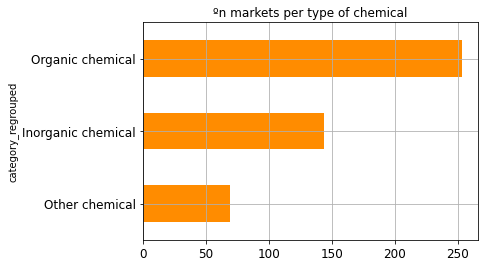

In [39]:
# Grouping by 'category_regrouped' and ploting the size of each group on a barh plot (in one line)
df_base_full_wCAS_woOutliersRMDk9a5 = outlier_detectors.make_full_df_after_outlier_detection_method(
    df_to_detect_RMDm, df_clean_metNtlNpr_RMDm
)
internal_funcs.plot_categories(
    df_in=df_base_full_wCAS_woOutliersRMDk9a5,
    groupby="category_regrouped",
    color="darkorange",
    fontsize=12,
)

activity_ISICclass
2011:Manufacture of basic chemicals                                                 524
2013:Manufacture of plastics and synthetic rubber in primary forms                   81
1920:Manufacture of refined petroleum products                                       59
2021:Manufacture of pesticides and other agrochemical products                       51
2023:Manufacture of soap and detergents, cleaning and polishing preparations, pe     30
2022:Manufacture of paints, varnishes and similar coatings, printing ink and mas     24
2029:Manufacture of other chemical products n.e.c.                                   20
2012:Manufacture of fertilizers and nitrogen compounds                               18
0161:Support activities for crop production                                          13
2011a: Manufacture of nuclear fuels                                                  13
2220:Manufacture of plastics products                                                11
3830:Material

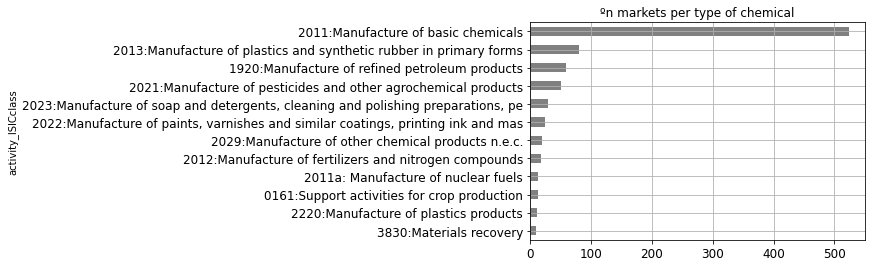

In [40]:
internal_funcs.plot_categories(
#     df_in=df_base_full_wCAS_woOutliersRMDk9a5,
#     df_in=df_analysis,
#         df_in=df_base_full, 
#     df_in=df_base_full_wCAS,
    df_in=df_cpc33to36, 
    groupby="activity_ISICclass",
    cutoff_value=10,
    color="gray",
    fontsize=12,
)

In [41]:
# df_cpc33to36[df_cpc33to36.activity_ISICclass=="1920:Manufacture of refined petroleum products"]

In [42]:
# sorted(df_base_full_wCAS_woOutliersRMDk9a5.activity_ISICclass.unique())
# sorted(df_base_full_wCAS.activity_ISICclass.unique())
# sorted(df_analysis.activity_ISICclass.unique())
sorted(df_base_full.activity_ISICclass.unique())

['0161:Support activities for crop production',
 '0220:Logging',
 '0729:Mining of other non-ferrous metal ores',
 '0891:Mining of chemical and fertilizer minerals',
 '1312:Weaving of textiles',
 '1920:Manufacture of refined petroleum products',
 '19a: Liquid and gaseous fuels from biomass',
 '2011:Manufacture of basic chemicals',
 '2011a: Manufacture of nuclear fuels',
 '2012:Manufacture of fertilizers and nitrogen compounds',
 '2013:Manufacture of plastics and synthetic rubber in primary forms',
 '2021:Manufacture of pesticides and other agrochemical products',
 '2022:Manufacture of paints, varnishes and similar coatings, printing ink and mas',
 '2023:Manufacture of soap and detergents, cleaning and polishing preparations, pe',
 '2029:Manufacture of other chemical products n.e.c.',
 '2030:Manufacture of man-made fibres',
 '20:Manufacture of chemicals and chemical products',
 '2100:Manufacture of pharmaceuticals, medicinal chemical and botanical products',
 '2219:Manufacture of other r

In [43]:
# df_base_full_wCAS_woOutliersRMDk9a5.shape
df_base_full_wCAS.shape

(492, 48)

In [44]:
# df_base_full_wCAS_woOutliersRMDk9a5[
#     df_base_full_wCAS_woOutliersRMDk9a5.activity_ISICclass.isin(
# df_base_full_wCAS[
#     df_base_full_wCAS.activity_ISICclass.isin(
df_base_full[
    df_base_full.activity_ISICclass.isin(
        [
            '0891:Mining of chemical and fertilizer minerals',
#             "2011:Manufacture of basic chemicals", # 361
#             "2011a: Manufacture of nuclear fuels", # 5
#             "2012:Manufacture of fertilizers and nitrogen compounds", # 11
#             "2013:Manufacture of plastics and synthetic rubber in primary forms", # 37
#             "2021:Manufacture of pesticides and other agrochemical products", # 20
#             "2023:Manufacture of soap and detergents, cleaning and polishing preparations, pe", # 7
#             "2029:Manufacture of other chemical products n.e.c.", # 4
#             "20:Manufacture of chemicals and chemical products", # 2
        ]
    )
]#.shape

,Activity,category_regrouped,activity_comment,type,referenceProduct,category,inline_comment,geo,activity_ISICclass,activity_ecoSpold01class,technologyLevel,referenceProductAmount,referenceProductUnit,referenceProduct_prodVolume,referenceProduct_prodVolumeComment,referenceProduct_price,referenceProduct_priceUnit,referenceProduct_priceComment,referenceProduct_casNumber,referenceProduct_CPCclass,activity_generalComment,sourceFilename,pubchem_match,num_matches,MF,MW,iupac,complexity,synonyms,"('IPCC 2013 GWP 100a V1.03', 'IPCC GWP 100a', 'kg CO2 eq')","('PBs-LCIA (baseline) V0.72', 'Climate change - CO2 concentration', 'ppm')","('PBs-LCIA (baseline) V0.72', 'Climate change - Energy imbalance', 'Wm-2')","('PBs-LCIA (baseline) V0.72', 'Stratospheric ozone depletion', 'DU')","('PBs-LCIA (baseline) V0.72', 'Ocean acidification', 'Omega Aragon')","('PBs-LCIA (baseline) V0.72', 'Biogeochemical flows - P', 'Tg P')","('PBs-LCIA (baseline) V0.72', 'Biogeochemical flows - N', 'Tg N')","('PBs-LCIA (baseline) V0.72', 'Land-system change - Global', '%')","('PBs-LCIA (baseline) V0.72', 'Freshwater use - Global', 'km3')","('PBs-LCIA (baseline) V0.72', 'Change in biosphere integrity - BII loss', '% BII loss')","TL in ('PBs-LCIA (baseline) V0.72', 'Climate change - CO2 concentration', 'ppm')","TL in ('PBs-LCIA (baseline) V0.72', 'Climate change - Energy imbalance', 'Wm-2')","TL in ('PBs-LCIA (baseline) V0.72', 'Stratospheric ozone depletion', 'DU')","TL in ('PBs-LCIA (baseline) V0.72', 'Ocean acidification', 'Omega Aragon')","TL in ('PBs-LCIA (baseline) V0.72', 'Biogeochemical flows - P', 'Tg P')","TL in ('PBs-LCIA (baseline) V0.72', 'Biogeochemical flows - N', 'Tg N')","TL in ('PBs-LCIA (baseline) V0.72', 'Land-system change - Global', '%')","TL in ('PBs-LCIA (baseline) V0.72', 'Freshwater use - Global', 'km3')","TL in ('PBs-LCIA (baseline) V0.72', 'Change in biosphere integrity - BII loss', '% BII loss')"
272,"Boric acid, anhydrous, powder {GLO}| market fo...",Other chemical,Production volume: 750000000 kgIncluded act...,Products,"Boric acid, anhydrous, powder",Chemicals\Acids (inorganic)\Market,Production Volume Amount: 750000000,GLO,0891:Mining of chemical and fertilizer minerals,chemicals/inorganics,0.0,1,kg,7.500000e+08,NaN,1.679153,USD2018,Calculated based on inputs: The price of the p...,10043-35-3,34: Basic chemicals,NaN,20800_038c0bbc-8cb3-448d-8d63-5b907c0ce670_49b...,by CAS,1,BH3O3,61.84,boric acid,8.0,"['BORIC ACID', 'Orthoboric acid', '10043-35-3'...",1.026287,2.551617e-11,3.440426e-13,6.186667e-15,7.797083e-14,5.993560e-16,1.100165e-13,6.171569e-16,4.143377e-12,2.556316e-13,15.575748,15.120918,0.018752,4.966484,0.002661,0.077989,0.001085,0.045526,1.123519
294,"Calcium borates {GLO}| market for | APOS, S",Other chemical,Production volume: 16660000000 kgIncluded a...,Products,Calcium borates,Chemicals\Inorganic\Market,Production Volume Amount: 16660000000,GLO,0891:Mining of chemical and fertilizer minerals,chemicals/inorganics,0.0,1,kg,1.666000e+10,NaN,0.631476,USD2018,Calculated value based on data from United Nat...,NaN,346: Fertilizers and pesticides,NaN,20847_113568bc-8b96-4fb6-b10b-de808de95f53_710...,No match,0,NaN,NaN,NaN,NaN,NaN,0.146463,3.805763e-12,5.067478e-14,1.065900e-15,1.162945e-14,1.599828e-17,3.764597e-15,2.025648e-16,1.871730e-13,3.788594e-14,6.177439,5.922308,0.008591,1.969742,0.000189,0.007096,0.000947,0.005469,0.442769
626,"Phosphate rock, as P2O5, beneficiated, dry {GL...",Other chemical,Production volume: 26705000000 kgIncluded a...,Products,"Phosphate rock, as P2O5, beneficiated, dry",Chemicals\Inorganic\Market,Production Volume Amount: 26705000000,GLO,0891:Mining of chemical and fertilizer minerals,chemicals/inorganics,0.0,1,kg,2.670500e+10,NaN,0.070324,USD2018,Calculated value based on data from United Nat...,065996-94-3,"34629: Other phosphatic fertilizers, n.e.c.",NaN,22683_57387112-6fd0-4c60-a0ca-495f762836a3_6dc...,by NAME,1,Ca5FO12P3,504.30,pentacalcium;fluoride;triphosphate,36.8,"['Fluora

### apply Tukey method to detect outliers (univariate)

In [45]:
# df_to_detect_Tm = df_base_full
df_to_detect_Tm = df_base_full_wCAS

df_clean_tukey, df_outliers_tukey = outlier_detectors.tukey_method_bulk(
    df_to_detect_Tm[lst_methods + lst_methods_TLs + ["referenceProduct_price"]],
    outlier_detection_fence="tight",
)
print("out of", df_to_detect_Tm.shape[0], "items")
print("Tukey univariate method detected:")
for i in df_outliers_tukey.columns:
    print("in ", i, ">>>>> ", df_outliers_tukey[i].count(), "outliers.")

out of 492 items
Tukey univariate method detected:
in  ('IPCC 2013 GWP 100a V1.03', 'IPCC GWP 100a', 'kg CO2 eq') >>>>>  52 outliers.
in  ('PBs-LCIA (baseline) V0.72', 'Climate change - CO2 concentration', 'ppm') >>>>>  48 outliers.
in  ('PBs-LCIA (baseline) V0.72', 'Climate change - Energy imbalance', 'Wm-2') >>>>>  52 outliers.
in  ('PBs-LCIA (baseline) V0.72', 'Stratospheric ozone depletion', 'DU') >>>>>  89 outliers.
in  ('PBs-LCIA (baseline) V0.72', 'Ocean acidification', 'Omega Aragon') >>>>>  48 outliers.
in  ('PBs-LCIA (baseline) V0.72', 'Biogeochemical flows - P', 'Tg P') >>>>>  86 outliers.
in  ('PBs-LCIA (baseline) V0.72', 'Biogeochemical flows - N', 'Tg N') >>>>>  89 outliers.
in  ('PBs-LCIA (baseline) V0.72', 'Land-system change - Global', '%') >>>>>  50 outliers.
in  ('PBs-LCIA (baseline) V0.72', 'Freshwater use - Global', 'km3') >>>>>  65 outliers.
in  ('PBs-LCIA (baseline) V0.72', 'Change in biosphere integrity - BII loss', '% BII loss') >>>>>  55 outliers.
in  TL in ('

### apply Mahalanobis Distance method to detect outliers depending on CATEGORY

In [46]:
# chemical_cat = "Organic chemical"
chemical_cat = "Inorganic chemical"
# chemical_cat = "Other chemical"
# df_to_detect_MDmCAT = df_base_full[df_base_full.category_regrouped==chemical_cat]
df_to_detect_MDmCAT = df_base_full_wCAS[
    df_base_full_wCAS.category_regrouped == chemical_cat
]

(
    df_clean_metNtlNpr_MDmCAT,
    df_outliers_metNtlNpr_MDmCAT,
    more_metNtlNpr_MDmCAT,
) = outlier_detectors.mahalanobis_method(
    df_to_detect_MDmCAT[lst_methods + lst_methods_TLs + ["referenceProduct_price"]],
    alpha=(1 - 0.95),
)
print("out of", df_to_detect_MDmCAT.shape[0], "items")
print(len(more_metNtlNpr_MDmCAT[0]), "outliers detected")

outlier_detectors.make_full_df_after_outlier_detection_method(
    df_to_detect_MDmCAT, df_outliers_metNtlNpr_MDmCAT
)[
    ["referenceProduct"]
    + [lst_methods[0]]
    + [lst_methods_TLs[0]]
    + ["referenceProduct_price"]
]

# df_clean_metNtlNpr_MDmCAT.sort_values(by="('IPCC 2013 GWP 100a V1.03', 'IPCC GWP 100a', 'kg CO2 eq')").tail(5)

out of 151 items
25 outliers detected


,referenceProduct,"('IPCC 2013 GWP 100a V1.03', 'IPCC GWP 100a', 'kg CO2 eq')","TL in ('PBs-LCIA (baseline) V0.72', 'Climate change - CO2 concentration', 'ppm')",referenceProduct_price
301,Calcium nitrate,3.132682,54.344039,0.678837
442,"Gallium, semiconductor-grade",145.732450,8.076758,430.552151
459,Heavy water,1616.912100,46.942157,889.807779
460,Helium,8.753025,15.018336,11.954998
461,"Helium, crude stockpiling",1.952384,68.282645,0.617125
484,Indium,215.666280,4.375517,1227.073631
517,Lithium,48.094069,17.656293,69.503077
566,Neodymium oxide,25.676907,39.523014,16.360982
635,"Phosphorus, white, liquid",12.060422,109.485167,2.827292
702,Praseodymium oxide,24.103360,39.528435,15.356360


In [47]:
df_base_full_wCAS.loc[162:163]

,Activity,category_regrouped,activity_comment,type,referenceProduct,category,inline_comment,geo,activity_ISICclass,activity_ecoSpold01class,technologyLevel,referenceProductAmount,referenceProductUnit,referenceProduct_prodVolume,referenceProduct_prodVolumeComment,referenceProduct_price,referenceProduct_priceUnit,referenceProduct_priceComment,referenceProduct_casNumber,referenceProduct_CPCclass,activity_generalComment,sourceFilename,pubchem_match,num_matches,MF,MW,iupac,complexity,synonyms,"('IPCC 2013 GWP 100a V1.03', 'IPCC GWP 100a', 'kg CO2 eq')","('PBs-LCIA (baseline) V0.72', 'Climate change - CO2 concentration', 'ppm')","('PBs-LCIA (baseline) V0.72', 'Climate change - Energy imbalance', 'Wm-2')","('PBs-LCIA (baseline) V0.72', 'Stratospheric ozone depletion', 'DU')","('PBs-LCIA (baseline) V0.72', 'Ocean acidification', 'Omega Aragon')","('PBs-LCIA (baseline) V0.72', 'Biogeochemical flows - P', 'Tg P')","('PBs-LCIA (baseline) V0.72', 'Biogeochemical flows - N', 'Tg N')","('PBs-LCIA (baseline) V0.72', 'Land-system change - Global', '%')","('PBs-LCIA (baseline) V0.72', 'Freshwater use - Global', 'km3')","('PBs-LCIA (baseline) V0.72', 'Change in biosphere integrity - BII loss', '% BII loss')","TL in ('PBs-LCIA (baseline) V0.72', 'Climate change - CO2 concentration', 'ppm')","TL in ('PBs-LCIA (baseline) V0.72', 'Climate change - Energy imbalance', 'Wm-2')","TL in ('PBs-LCIA (baseline) V0.72', 'Stratospheric ozone depletion', 'DU')","TL in ('PBs-LCIA (baseline) V0.72', 'Ocean acidification', 'Omega Aragon')","TL in ('PBs-LCIA (baseline) V0.72', 'Biogeochemical flows - P', 'Tg P')","TL in ('PBs-LCIA (baseline) V0.72', 'Biogeochemical flows - N', 'Tg N')","TL in ('PBs-LCIA (baseline) V0.72', 'Land-system change - Global', '%')","TL in ('PBs-LCIA (baseline) V0.72', 'Freshwater use - Global', 'km3')","TL in ('PBs-LCIA (baseline) V0.72', 'Change in biosphere integrity - BII loss', '% BII loss')"
162,"Uranium, enriched 3.9%, in fuel element for li...",Other chemical,Production volume: 1956521.73913044 kgInclu...,Products,"Uranium, enriched 3.9%, in fuel element for li...",Fuels\Uranium\Enriched\Market,Production Volume Amount: 1956521.73913044,GLO,2011a: Manufacture of nuclear fuels,nuclear power/production,0.0,1,kg,1.956522e+06,NaN,841.011869,USD2018,Calculated based on inputs: The price of the p...,NaN,33620: Uranium enriched in U235 and its compou...,NaN,23456_55ad48f7-f8ad-4d6c-9359-ab54d77ae94a_e4b...,by NAME,1,U,238.0289,uranium,0.0,"['7440-61-1', 'U', 'Uranium', 'Uranium, natura...",3558.2903,8.025498e-08,1.154215e-09,1.898091e-10,2.452385e-10,2.066723e-12,1.552963e-09,5.197372e-13,5.860487e-08,8.384247e-10,97.812362,101.283999,1.148691,31.188450,0.018319,2.197979,0.001824,1.285665,7.357297
163,"Uranium, enriched 4%, in fuel element for ligh...",Other chemical,Production volume: 1888111.88811189 kgInclu...,Products,"Uranium, enriched 4%, in fuel element for ligh...",Fuels\Uranium\Enriched\Market,Production Volume Amount: 1888111.88811189,GLO,2011a: Manufacture of nuclear fuels,nuclear power/production,0.0,1,kg,1.888112e+06,NaN,841.011869,USD2018,Calculated based on inputs: The price of the p...,NaN,33620: Uranium enriched in U235 and its compou...,NaN,23460_7de5c877-0fd7-4362-8a8f-c71d07fd7626_83f...,by NAME,1,U,238.0289,uranium,0.0,"['7440-61-1', 'U', 'Uranium', 'Uranium, natura...",3669.2213,8.270946e-08,1.189948e-09,1.964145e-10,2.527388e-10,2.121208e-12,1.590683e-09,5.333078e-13,6.024732e-08,8.643606e-10,100.803808,104.419621,1.188666,32.142303,0.018802,2.251366,0.001872,1.321697,7.584888


# Insight from the data

In [48]:
df_for_insights = df_base_full_wCAS_woOutliersRMDk9a5

In [49]:
lst_methods_TLs

["TL in ('PBs-LCIA (baseline) V0.72', 'Climate change - CO2 concentration', 'ppm')",
 "TL in ('PBs-LCIA (baseline) V0.72', 'Climate change - Energy imbalance', 'Wm-2')",
 "TL in ('PBs-LCIA (baseline) V0.72', 'Stratospheric ozone depletion', 'DU')",
 "TL in ('PBs-LCIA (baseline) V0.72', 'Ocean acidification', 'Omega Aragon')",
 "TL in ('PBs-LCIA (baseline) V0.72', 'Biogeochemical flows - P', 'Tg P')",
 "TL in ('PBs-LCIA (baseline) V0.72', 'Biogeochemical flows - N', 'Tg N')",
 "TL in ('PBs-LCIA (baseline) V0.72', 'Land-system change - Global', '%')",
 "TL in ('PBs-LCIA (baseline) V0.72', 'Freshwater use - Global', 'km3')",
 "TL in ('PBs-LCIA (baseline) V0.72', 'Change in biosphere integrity - BII loss', '% BII loss')"]

In [50]:
num_chemicals_tot = df_for_insights.shape[0]
num_chemicals_tot

466

#### * functions

In [51]:
def ecdf(ar):
    """Create df with empirical CDF data.
    
    eCDF - empirical Cumulative Distribution Function
    
    Parameters
    ----------
    ar: 1-D array-like
        Input array, should be 1-D pandas series
    
    Returns
    -------
    df_out: DataFrame
        Dataframe containing the original index of the input data with
        - column, named as passed data, containing ordered input items, 
        - column, named "counts", containing the number of times each unique item appears
        - column, named "cumsum", containing the cumulate sum of counts
        - column, named "Probability", containing the cumulative probability of occurance of each item
    """
    x, indices, counts = np.unique(ar, return_index=True, return_counts=True)
    cusum = np.cumsum(counts)
    prob = cusum / cusum[-1] 
    df_out = pd.DataFrame({ar.name: x, "counts": counts, "cumsum": cusum, "Probability": prob}, index=indices)
    
    return df_out

In [52]:
import functools
def conjunction(*conditions):
    """All conditions met at the same time"""
    return functools.reduce(np.logical_and, conditions)

def disjunction(*conditions):
    """Any condition met"""
    return functools.reduce(np.logical_or, conditions)

## % of chemicals transgressing at least one PB?

In [53]:
c1 = df_for_insights[lst_methods_TLs[0]] > 1
c2 = df_for_insights[lst_methods_TLs[1]] > 1
c3 = df_for_insights[lst_methods_TLs[2]] > 1
c4 = df_for_insights[lst_methods_TLs[3]] > 1
c5 = df_for_insights[lst_methods_TLs[4]] > 1
c6 = df_for_insights[lst_methods_TLs[5]] > 1
c7 = df_for_insights[lst_methods_TLs[6]] > 1
c8 = df_for_insights[lst_methods_TLs[7]] > 1
c9 = df_for_insights[lst_methods_TLs[8]] > 1

num_chemicals_trans_at_least_onePB = df_for_insights[
    disjunction(c1, c2, c3, c4, c5, c6, c7, c8, c9)
].shape[0]
print(
    "{} of the chemicals transgress at least one PB, i.e., {}% of the dataset.".format(
        num_chemicals_trans_at_least_onePB,
        round(num_chemicals_trans_at_least_onePB/num_chemicals_tot*100, 2)
    )
)

# df_for_insights[disjunction(c1, c2, c3, c4, c5, c6, c7, c8, c9)]

463 of the chemicals transgress at least one PB, i.e., 99.36% of the dataset.


## % of chemicals absolute sustainable?

In [54]:
c1 = df_for_insights[lst_methods_TLs[0]] <= 1
c2 = df_for_insights[lst_methods_TLs[1]] <= 1
c3 = df_for_insights[lst_methods_TLs[2]] <= 1
c4 = df_for_insights[lst_methods_TLs[3]] <= 1
c5 = df_for_insights[lst_methods_TLs[4]] <= 1
c6 = df_for_insights[lst_methods_TLs[5]] <= 1
c7 = df_for_insights[lst_methods_TLs[6]] <= 1
c8 = df_for_insights[lst_methods_TLs[7]] <= 1
c9 = df_for_insights[lst_methods_TLs[8]] <= 1

num_chemicals_abs_sustainable = df_for_insights[
    conjunction(c1, c2, c3, c4, c5, c6, c7, c8, c9)
].shape[0]
print(
    "{} of the chemicals are absolute sustainable ({}% of the dataset),"
    " i.e., they don't transgress any of the PBs.".format(
        num_chemicals_abs_sustainable,
        round(num_chemicals_abs_sustainable / num_chemicals_tot * 100, 2),
    )
)

df_for_insights[conjunction(c1, c2, c3, c4, c5, c6, c7, c8, c9)]

3 of the chemicals are absolute sustainable (0.64% of the dataset), i.e., they don't transgress any of the PBs.


,Activity,category_regrouped,activity_comment,type,referenceProduct,category,inline_comment,geo,activity_ISICclass,activity_ecoSpold01class,technologyLevel,referenceProductAmount,referenceProductUnit,referenceProduct_prodVolume,referenceProduct_prodVolumeComment,referenceProduct_price,referenceProduct_priceUnit,referenceProduct_priceComment,referenceProduct_casNumber,referenceProduct_CPCclass,activity_generalComment,sourceFilename,pubchem_match,num_matches,MF,MW,iupac,complexity,synonyms,"('IPCC 2013 GWP 100a V1.03', 'IPCC GWP 100a', 'kg CO2 eq')","('PBs-LCIA (baseline) V0.72', 'Climate change - CO2 concentration', 'ppm')","('PBs-LCIA (baseline) V0.72', 'Climate change - Energy imbalance', 'Wm-2')","('PBs-LCIA (baseline) V0.72', 'Stratospheric ozone depletion', 'DU')","('PBs-LCIA (baseline) V0.72', 'Ocean acidification', 'Omega Aragon')","('PBs-LCIA (baseline) V0.72', 'Biogeochemical flows - P', 'Tg P')","('PBs-LCIA (baseline) V0.72', 'Biogeochemical flows - N', 'Tg N')","('PBs-LCIA (baseline) V0.72', 'Land-system change - Global', '%')","('PBs-LCIA (baseline) V0.72', 'Freshwater use - Global', 'km3')","('PBs-LCIA (baseline) V0.72', 'Change in biosphere integrity - BII loss', '% BII loss')","TL in ('PBs-LCIA (baseline) V0.72', 'Climate change - CO2 concentration', 'ppm')","TL in ('PBs-LCIA (baseline) V0.72', 'Climate change - Energy imbalance', 'Wm-2')","TL in ('PBs-LCIA (baseline) V0.72', 'Stratospheric ozone depletion', 'DU')","TL in ('PBs-LCIA (baseline) V0.72', 'Ocean acidification', 'Omega Aragon')","TL in ('PBs-LCIA (baseline) V0.72', 'Biogeochemical flows - P', 'Tg P')","TL in ('PBs-LCIA (baseline) V0.72', 'Biogeochemical flows - N', 'Tg N')","TL in ('PBs-LCIA (baseline) V0.72', 'Land-system change - Global', '%')","TL in ('PBs-LCIA (baseline) V0.72', 'Freshwater use - Global', 'km3')","TL in ('PBs-LCIA (baseline) V0.72', 'Change in biosphere integrity - BII loss', '% BII loss')",p_value
464,"Hexamethyldisilazane {GLO}| market for | APOS, S",Organic chemical,Production volume: 1800000 kgIncluded activ...,Products,Hexamethyldisilazane,Chemicals\Organic\Market,Production Volume Amount: 1800000,GLO,2011:Manufacture of basic chemicals,chemicals/inorganics,0.0,1,kg,1800000.0,NaN,153.563601,USD2018,Temporary price data. Calculated as 90% of pur...,999-97-3,34150: Amine-function compounds; oxygen-functi...,NaN,22005_4169779b-ba3e-4895-bed0-0206f6b3e619_1a7...,by CAS,1,C6H19NSi2,161.39,[dimethyl-(trimethylsilylamino)silyl]methane,76.2,"['Hexamethyldisilazane', '999-97-3', 'Bis(trim...",5.768447,1.394551e-10,1.874056e-12,3.707681e-14,4.261371e-13,6.901971e-15,6.919852e-13,8.280406e-16,1.284567e-11,1.438811e-12,0.930829,0.900639,0.001229,0.296803,0.000335,0.005364,0.000016,0.001543,0.069147,0.994216
723,"Selenium {GLO}| market for | APOS, S",Inorganic chemical,Production volume: 2200000 kgIncluded activ...,Products,Selenium,Chemicals\Inorganic\Market,Production Volume Amount: 2200000,GLO,2011:Manufacture of basic chemicals,chemicals/inorganics,0.0,1,kg,2200000.0,NaN,76.064213,USD2018,Calculated value based on data from United Nat...,7782-49-2,34231: Chemical elements n.e.c.; inorganic aci...,NaN,23057_f5827b41-37f6-4125-a2cf-fd587a4c694f_f77...,by CAS,1,Se,78.97,selenium,0.0,"['7782-49-2', 'Se', 'Selenium', 'SELENIUM ATOM...",2.626958,6.410956e-11,8.683298e-13,1.621723e-14,1.959020e-13,3.093249e-14,9.958491e-13,5.829078e-16,7.907995e-12,6.952369e-13,0.863906,0.842482,0.001085,0.275465,0.003031,0.015584,0.000023,0.001918,0.067454,0.994163
851,"Trimesoyl chloride {GLO}| market for | APOS, S",Inorganic chemical,Production volume: 4 kgIncluded activities ...,Products,Trimesoyl chloride,Chemicals\Organic\Market,Production Volume Amount: 4,GLO,2011:Manufacture of basic chemicals,chemicals/organics,0.0,1,kg,4.0,NaN,1420.822099,USD2018,Estimated based on purchaser prices available ...,4422-95-1,342: Basic inorganic chemicals n.e.c.,NaN,23442_5a2c7eef-c5cb-4f96-b3ca-95abd11a17b2_4c4...,by CAS,1,C9H3Cl3O3,265.50,"benzene-1,3

## % of chemicals transgressing all the PBs at the same time?

In [55]:
c1 = df_for_insights[lst_methods_TLs[0]] > 1
c2 = df_for_insights[lst_methods_TLs[1]] > 1
c3 = df_for_insights[lst_methods_TLs[2]] > 1
c4 = df_for_insights[lst_methods_TLs[3]] > 1
c5 = df_for_insights[lst_methods_TLs[4]] > 1
c6 = df_for_insights[lst_methods_TLs[5]] > 1
c7 = df_for_insights[lst_methods_TLs[6]] > 1
c8 = df_for_insights[lst_methods_TLs[7]] > 1
c9 = df_for_insights[lst_methods_TLs[8]] > 1

num_chemicals_bad_in_allPBs = df_for_insights[
    conjunction(c1, c2, c3, c4, c5, c6, c7, c8, c9)
].shape[0]
print(
    "{} of the chemicals trasnsgress all the PBs simultaneously ({}% of the dataset)".format(
        num_chemicals_bad_in_allPBs,
        round(num_chemicals_bad_in_allPBs / num_chemicals_tot * 100, 2),
    )
)

df_for_insights[conjunction(c1, c2, c3, c4, c5, c6, c7, c8, c9)]

0 of the chemicals trasnsgress all the PBs simultaneously (0.0% of the dataset)


,Activity,category_regrouped,activity_comment,type,referenceProduct,category,inline_comment,geo,activity_ISICclass,activity_ecoSpold01class,technologyLevel,referenceProductAmount,referenceProductUnit,referenceProduct_prodVolume,referenceProduct_prodVolumeComment,referenceProduct_price,referenceProduct_priceUnit,referenceProduct_priceComment,referenceProduct_casNumber,referenceProduct_CPCclass,activity_generalComment,sourceFilename,pubchem_match,num_matches,MF,MW,iupac,complexity,synonyms,"('IPCC 2013 GWP 100a V1.03', 'IPCC GWP 100a', 'kg CO2 eq')","('PBs-LCIA (baseline) V0.72', 'Climate change - CO2 concentration', 'ppm')","('PBs-LCIA (baseline) V0.72', 'Climate change - Energy imbalance', 'Wm-2')","('PBs-LCIA (baseline) V0.72', 'Stratospheric ozone depletion', 'DU')","('PBs-LCIA (baseline) V0.72', 'Ocean acidification', 'Omega Aragon')","('PBs-LCIA (baseline) V0.72', 'Biogeochemical flows - P', 'Tg P')","('PBs-LCIA (baseline) V0.72', 'Biogeochemical flows - N', 'Tg N')","('PBs-LCIA (baseline) V0.72', 'Land-system change - Global', '%')","('PBs-LCIA (baseline) V0.72', 'Freshwater use - Global', 'km3')","('PBs-LCIA (baseline) V0.72', 'Change in biosphere integrity - BII loss', '% BII loss')","TL in ('PBs-LCIA (baseline) V0.72', 'Climate change - CO2 concentration', 'ppm')","TL in ('PBs-LCIA (baseline) V0.72', 'Climate change - Energy imbalance', 'Wm-2')","TL in ('PBs-LCIA (baseline) V0.72', 'Stratospheric ozone depletion', 'DU')","TL in ('PBs-LCIA (baseline) V0.72', 'Ocean acidification', 'Omega Aragon')","TL in ('PBs-LCIA (baseline) V0.72', 'Biogeochemical flows - P', 'Tg P')","TL in ('PBs-LCIA (baseline) V0.72', 'Biogeochemical flows - N', 'Tg N')","TL in ('PBs-LCIA (baseline) V0.72', 'Land-system change - Global', '%')","TL in ('PBs-LCIA (baseline) V0.72', 'Freshwater use - Global', 'km3')","TL in ('PBs-LCIA (baseline) V0.72', 'Change in biosphere integrity - BII loss', '% BII loss')",p_value


## % of chemicals transgressing each PB? (or above/below any value of TL)

In [56]:
cat_of_interest = lst_methods_TLs[5]
df = df_for_insights[cat_of_interest]

df_out = ecdf(df)

stored_indices = []  # they are indices of df_out, not df
indices_duplicated_scores = []  # they are indices of df_out, not df

for ix in df_out.index:
    if df_out[df.name][ix] <= 1:
        print_prob = df_out.Probability[ix]
        print_item = df_out[df.name][ix]
        stored_indices.append(ix)
    if df_out.counts[ix] != 1:
        indices_duplicated_scores.append(ix)

# find the chemicals in the original df (translate indices from df_out to df)
# for stored_indices:
df_from_stored_indices = df_for_insights[
    df_for_insights[cat_of_interest].isin(df_out[cat_of_interest][stored_indices])
]

# for indices_duplicated_scores:
df_from_duplicated_scores = df_for_insights[
    df_for_insights[cat_of_interest].isin(
        df_out[cat_of_interest][indices_duplicated_scores]
    )
]

print(
    "set of chemicals not transgressing the PB: {} of {}".format(
        df_from_stored_indices.shape[0], df_for_insights.shape[0]
    )
)
print("Probability of the set:", np.round(print_prob, 3))
print("Max value of TL included in set, max(TL)=", print_item)

print(
    "{} % of chemicals are transgesssed in {}".format(
        np.round((1 - print_prob) * 100, 2), df.name
    )
)

# visualize the data (uncomment)
# df_from_duplicated_scores
df_from_stored_indices

set of chemicals not transgressing the PB: 340 of 466
Probability of the set: 0.73
Max value of TL included in set, max(TL)= 0.9961510931083362
27.04 % of chemicals are transgesssed in TL in ('PBs-LCIA (baseline) V0.72', 'Biogeochemical flows - N', 'Tg N')


,Activity,category_regrouped,activity_comment,type,referenceProduct,category,inline_comment,geo,activity_ISICclass,activity_ecoSpold01class,technologyLevel,referenceProductAmount,referenceProductUnit,referenceProduct_prodVolume,referenceProduct_prodVolumeComment,referenceProduct_price,referenceProduct_priceUnit,referenceProduct_priceComment,referenceProduct_casNumber,referenceProduct_CPCclass,activity_generalComment,sourceFilename,pubchem_match,num_matches,MF,MW,iupac,complexity,synonyms,"('IPCC 2013 GWP 100a V1.03', 'IPCC GWP 100a', 'kg CO2 eq')","('PBs-LCIA (baseline) V0.72', 'Climate change - CO2 concentration', 'ppm')","('PBs-LCIA (baseline) V0.72', 'Climate change - Energy imbalance', 'Wm-2')","('PBs-LCIA (baseline) V0.72', 'Stratospheric ozone depletion', 'DU')","('PBs-LCIA (baseline) V0.72', 'Ocean acidification', 'Omega Aragon')","('PBs-LCIA (baseline) V0.72', 'Biogeochemical flows - P', 'Tg P')","('PBs-LCIA (baseline) V0.72', 'Biogeochemical flows - N', 'Tg N')","('PBs-LCIA (baseline) V0.72', 'Land-system change - Global', '%')","('PBs-LCIA (baseline) V0.72', 'Freshwater use - Global', 'km3')","('PBs-LCIA (baseline) V0.72', 'Change in biosphere integrity - BII loss', '% BII loss')","TL in ('PBs-LCIA (baseline) V0.72', 'Climate change - CO2 concentration', 'ppm')","TL in ('PBs-LCIA (baseline) V0.72', 'Climate change - Energy imbalance', 'Wm-2')","TL in ('PBs-LCIA (baseline) V0.72', 'Stratospheric ozone depletion', 'DU')","TL in ('PBs-LCIA (baseline) V0.72', 'Ocean acidification', 'Omega Aragon')","TL in ('PBs-LCIA (baseline) V0.72', 'Biogeochemical flows - P', 'Tg P')","TL in ('PBs-LCIA (baseline) V0.72', 'Biogeochemical flows - N', 'Tg N')","TL in ('PBs-LCIA (baseline) V0.72', 'Land-system change - Global', '%')","TL in ('PBs-LCIA (baseline) V0.72', 'Freshwater use - Global', 'km3')","TL in ('PBs-LCIA (baseline) V0.72', 'Change in biosphere integrity - BII loss', '% BII loss')",p_value
5,"Polymethyl methacrylate, sheet {GLO}| market f...",Organic chemical,"In this market, expert judgement was used to d...",Products,"Polymethyl methacrylate, sheet",Plastics\Thermoplasts\Market,Production Volume Amount: 4,GLO,2220:Manufacture of plastics products,plastics/polymers,0.0,1,kg,4.000000e+00,NaN,1.851374,USD2018,Temporary price data. Calculated as 90% of pur...,9011-14-7,"36330: Plates, sheets, film, foil and strip, o...","In this market, expert judgement was used to d...",22779_2ac4268e-9296-4301-8428-24f9922755ad_f82...,by NAME,1,C5H8O2,100.120000,methyl 2-methylprop-2-enoate,94.3,"['METHYL METHACRYLATE', '80-62-6', 'Methylmeth...",8.792979,1.952612e-10,2.595590e-12,8.431139e-16,5.966680e-13,1.900817e-13,1.258519e-12,2.868308e-17,1.024783e-12,1.897220e-12,108.104966,103.466149,0.002318,34.470360,0.765363,0.809152,0.000046,0.010213,7.562750,0.998226
13,"Urea formaldehyde foam, in situ foaming {GLO}|...",Organic chemical,"In this market, expert judgement was used to d...",Products,"Urea formaldehyde foam, in situ foaming",Construction\Insulation\Market,Production Volume Amount: 4,GLO,2220:Manufacture of plastics products,insulation materials/production,0.0,1,kg,4.000000e+00,NaN,2.540258,USD2018,Calculated from EU prices by use of exchange r...,NaN,363: Semi-manufactures of plastics,"In this market, expert judgement was used to d...",23466_0b74180d-2a09-446c-a051-21637de5af84_414...,by NAME,1,C2H6N2O2,90.080000,formaldehyde;urea,31.0,"['Urea formaldehyde', 'Polynoxylin', '9011-05-...",2.925079,7.169564e-11,9.548867e-13,1.286740e-14,2.190830e-13,4.263286e-15,2.924785e-13,9.729153e-16,4.945009e-12,6.940616e-13,28.929362,27.741532,0.025781,9.224401,0.012511,0.137051,0.001131,0.035916,2.016400,0.999932
22,"Activated carbon, granular {GLO}| market for a...",Other chemical,The transport amounts are based on the default...,Products,"Activated carbon, granular",Chemicals\Organic\Market,Production Volume Amount: 1540000000,GLO,2029:Manufacture of other chemical products n....,NaN,NaN,1,kg,1.540000e+09,NaN,1.349063,USD2018,Calcula

## maximum/minimum TL for each PB

In [57]:
df_for_insights[lst_methods_TLs].max()

TL in ('PBs-LCIA (baseline) V0.72', 'Climate change - CO2 concentration', 'ppm')                 239.153849
TL in ('PBs-LCIA (baseline) V0.72', 'Climate change - Energy imbalance', 'Wm-2')                 231.220508
TL in ('PBs-LCIA (baseline) V0.72', 'Stratospheric ozone depletion', 'DU')                        11.876769
TL in ('PBs-LCIA (baseline) V0.72', 'Ocean acidification', 'Omega Aragon')                        76.256610
TL in ('PBs-LCIA (baseline) V0.72', 'Biogeochemical flows - P', 'Tg P')                           14.159472
TL in ('PBs-LCIA (baseline) V0.72', 'Biogeochemical flows - N', 'Tg N')                          128.928553
TL in ('PBs-LCIA (baseline) V0.72', 'Land-system change - Global', '%')                            0.019685
TL in ('PBs-LCIA (baseline) V0.72', 'Freshwater use - Global', 'km3')                              2.270167
TL in ('PBs-LCIA (baseline) V0.72', 'Change in biosphere integrity - BII loss', '% BII loss')     18.485771
dtype: float64

In [58]:
df_for_insights[lst_methods_TLs].min()

TL in ('PBs-LCIA (baseline) V0.72', 'Climate change - CO2 concentration', 'ppm')                 0.124769
TL in ('PBs-LCIA (baseline) V0.72', 'Climate change - Energy imbalance', 'Wm-2')                 0.127107
TL in ('PBs-LCIA (baseline) V0.72', 'Stratospheric ozone depletion', 'DU')                       0.000071
TL in ('PBs-LCIA (baseline) V0.72', 'Ocean acidification', 'Omega Aragon')                       0.039784
TL in ('PBs-LCIA (baseline) V0.72', 'Biogeochemical flows - P', 'Tg P')                          0.000073
TL in ('PBs-LCIA (baseline) V0.72', 'Biogeochemical flows - N', 'Tg N')                          0.001786
TL in ('PBs-LCIA (baseline) V0.72', 'Land-system change - Global', '%')                         -0.003735
TL in ('PBs-LCIA (baseline) V0.72', 'Freshwater use - Global', 'km3')                            0.000117
TL in ('PBs-LCIA (baseline) V0.72', 'Change in biosphere integrity - BII loss', '% BII loss')    0.009829
dtype: float64

In [59]:
df_for_insights[lst_methods_TLs].max()/df_for_insights[lst_methods_TLs].min()

TL in ('PBs-LCIA (baseline) V0.72', 'Climate change - CO2 concentration', 'ppm')                   1916.770584
TL in ('PBs-LCIA (baseline) V0.72', 'Climate change - Energy imbalance', 'Wm-2')                   1819.095095
TL in ('PBs-LCIA (baseline) V0.72', 'Stratospheric ozone depletion', 'DU')                       168388.642889
TL in ('PBs-LCIA (baseline) V0.72', 'Ocean acidification', 'Omega Aragon')                         1916.774259
TL in ('PBs-LCIA (baseline) V0.72', 'Biogeochemical flows - P', 'Tg P')                          193466.719879
TL in ('PBs-LCIA (baseline) V0.72', 'Biogeochemical flows - N', 'Tg N')                           72203.001877
TL in ('PBs-LCIA (baseline) V0.72', 'Land-system change - Global', '%')                              -5.270002
TL in ('PBs-LCIA (baseline) V0.72', 'Freshwater use - Global', 'km3')                             19385.528634
TL in ('PBs-LCIA (baseline) V0.72', 'Change in biosphere integrity - BII loss', '% BII loss')      1880.664346
d

In [60]:
df_for_insights[df_for_insights.referenceProduct.isin(highlighted_product)][lst_methods_TLs].min()

TL in ('PBs-LCIA (baseline) V0.72', 'Climate change - CO2 concentration', 'ppm')                 13.151478
TL in ('PBs-LCIA (baseline) V0.72', 'Climate change - Energy imbalance', 'Wm-2')                 12.794606
TL in ('PBs-LCIA (baseline) V0.72', 'Stratospheric ozone depletion', 'DU')                        0.000128
TL in ('PBs-LCIA (baseline) V0.72', 'Ocean acidification', 'Omega Aragon')                        4.193442
TL in ('PBs-LCIA (baseline) V0.72', 'Biogeochemical flows - P', 'Tg P')                           0.000370
TL in ('PBs-LCIA (baseline) V0.72', 'Biogeochemical flows - N', 'Tg N')                           0.012972
TL in ('PBs-LCIA (baseline) V0.72', 'Land-system change - Global', '%')                          -0.000001
TL in ('PBs-LCIA (baseline) V0.72', 'Freshwater use - Global', 'km3')                             0.002115
TL in ('PBs-LCIA (baseline) V0.72', 'Change in biosphere integrity - BII loss', '% BII loss')     0.934112
dtype: float64

## sort by specific TL for each PB

In [61]:
df_for_insights.sort_values(by=lst_methods_TLs[4]).tail(24)

,Activity,category_regrouped,activity_comment,type,referenceProduct,category,inline_comment,geo,activity_ISICclass,activity_ecoSpold01class,technologyLevel,referenceProductAmount,referenceProductUnit,referenceProduct_prodVolume,referenceProduct_prodVolumeComment,referenceProduct_price,referenceProduct_priceUnit,referenceProduct_priceComment,referenceProduct_casNumber,referenceProduct_CPCclass,activity_generalComment,sourceFilename,pubchem_match,num_matches,MF,MW,iupac,complexity,synonyms,"('IPCC 2013 GWP 100a V1.03', 'IPCC GWP 100a', 'kg CO2 eq')","('PBs-LCIA (baseline) V0.72', 'Climate change - CO2 concentration', 'ppm')","('PBs-LCIA (baseline) V0.72', 'Climate change - Energy imbalance', 'Wm-2')","('PBs-LCIA (baseline) V0.72', 'Stratospheric ozone depletion', 'DU')","('PBs-LCIA (baseline) V0.72', 'Ocean acidification', 'Omega Aragon')","('PBs-LCIA (baseline) V0.72', 'Biogeochemical flows - P', 'Tg P')","('PBs-LCIA (baseline) V0.72', 'Biogeochemical flows - N', 'Tg N')","('PBs-LCIA (baseline) V0.72', 'Land-system change - Global', '%')","('PBs-LCIA (baseline) V0.72', 'Freshwater use - Global', 'km3')","('PBs-LCIA (baseline) V0.72', 'Change in biosphere integrity - BII loss', '% BII loss')","TL in ('PBs-LCIA (baseline) V0.72', 'Climate change - CO2 concentration', 'ppm')","TL in ('PBs-LCIA (baseline) V0.72', 'Climate change - Energy imbalance', 'Wm-2')","TL in ('PBs-LCIA (baseline) V0.72', 'Stratospheric ozone depletion', 'DU')","TL in ('PBs-LCIA (baseline) V0.72', 'Ocean acidification', 'Omega Aragon')","TL in ('PBs-LCIA (baseline) V0.72', 'Biogeochemical flows - P', 'Tg P')","TL in ('PBs-LCIA (baseline) V0.72', 'Biogeochemical flows - N', 'Tg N')","TL in ('PBs-LCIA (baseline) V0.72', 'Land-system change - Global', '%')","TL in ('PBs-LCIA (baseline) V0.72', 'Freshwater use - Global', 'km3')","TL in ('PBs-LCIA (baseline) V0.72', 'Change in biosphere integrity - BII loss', '% BII loss')",p_value
418,Ethylene glycol diethyl ether {GLO}| market fo...,Organic chemical,Production volume: 4 kgIncluded activities ...,Products,Ethylene glycol diethyl ether,Chemicals\Organic\Market,Production Volume Amount: 4,GLO,2011:Manufacture of basic chemicals,chemicals/organics,0.0,1,kg,4.000000e+00,NaN,1.047677,USD2018,Calculated value based on data from United Nat...,629-14-1,"34170: Ethers, alcohol peroxides, ether peroxi...",NaN,21705_b1796ee8-2aad-4092-94f5-a8d7a0e2b313_ff1...,by CAS,1,C6H14O2,118.170000,"1,2-diethoxyethane",31.5,"['1,2-Diethoxyethane', '629-14-1', 'ETHYLENE G...",3.436592,8.229527e-11,1.109670e-12,1.395684e-14,2.514730e-13,1.382348e-13,7.925297e-13,2.697399e-16,5.653973e-12,8.037187e-13,80.513992,78.166891,0.067803,25.672686,0.983583,0.900436,0.000760,0.099569,5.661520,0.999997
954,"Calcium chloride, combined to GLO market",Inorganic chemical,None,Products,Calcium chloride,Chemicals\Inorganic\Market,None,GLO,2011:Manufacture of basic chemicals,NaN,NaN,1,kg,8.749630e+10,None,0.180832,USD2018,None,010043-52-4,34240: Phosphates of triammonium; salts and pe...,"Combined activity, mass allocated from RER, Ro...",None,by NAME,1,CaCl2H4O2,147.010000,calcium;dichloride;dihydrate,2.8,"['CALCIUM CHLORIDE, DIHYDRATE', 'MFCD00149613'...",0.714434,1.765010e-11,2.353872e-13,2.797827e-15,5.393399e-14,2.483531e-14,1.124211e-13,7.088502e-17,1.261710e-12,2.107339e-13,100.045116,96.064775,0.078747,31.900298,1.023801,0.740010,0.001157,0.128730,8.600340,0.999716
195,"Acetoacetic acid {GLO}| market for | APOS, S",Organic chemical,Production volume: 10000000 kgIncluded acti...,Products,Acetoacetic acid,Chemicals\Acids (organic)\Market,Production Volume Amount: 10000000,GLO,2011:Manufacture of basic chemicals,NaN,0.0,1,kg,1.000000e+07,NaN,2.353685,USD2018,Calculated based on inputs: The price of the p...,NaN,"34140: Carboxylic acids and their anhydrides, ...",NaN,20628_c2f0309c-556f-4032-a30b-04e59e775337_dbb...,by NAME,1,C4H6O3,102.090000,3-oxobutanoic acid,95.1,"['acetoacetic acid', '3-oxobutanoic acid', '54...",8.258298,2.013323e-10,2

## For any PB: which chemicals transgress? to which category they belong?

In [62]:
# df_for_insights[df_for_insights.referenceProduct.isin(highlighted_product)]

TL in ('PBs-LCIA (baseline) V0.72', 'Biogeochemical flows - N', 'Tg N') 

category_regrouped
Organic chemical      50
Inorganic chemical    44
Other chemical        32
dtype: int64
Total:  126

Shares in % for  category_regrouped
Inorganic chemical    34.92
Organic chemical      39.68
Other chemical        25.40
dtype: float64
38.1 % fixate N directly


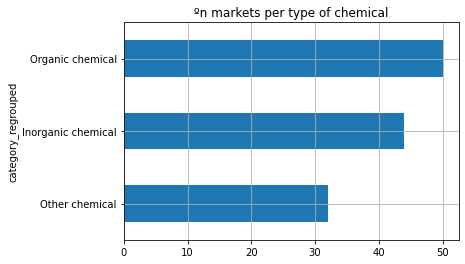

In [63]:
# ctg = lst_methods_TLs[6] # Land-system change - Global !!!! NO TRANSGRESSED CHEMICALS
# ctg = lst_methods_TLs[7] # Freshwater use - Global !!!! 7 transgressed
# ctg = lst_methods_TLs[2] # Stratospheric ozone depletion !!!! 33 transgressed
# ctg = lst_methods_TLs[4] # Biogeochemical flows - P !!!! 23 transgressed
ctg = lst_methods_TLs[5] # Biogeochemical flows - N !!!! 126 transgressed




print(ctg, "\n")
df_for_insights[df_for_insights[ctg] > 1].category_regrouped.unique()
df_for_insights[df_for_insights[ctg] > 1].activity_ISICclass.unique()
# sorted(df_for_insights[df_for_insights[lst_methods_TLs[5]]>1].referenceProduct_CPCclass.unique())

internal_funcs.plot_categories(
    df_for_insights[df_for_insights[ctg] > 1], # .between(1, 73.8, inclusive=True)
#     groupby="referenceProduct_CPCclass",
    groupby="category_regrouped",
    cutoff_value=0,
)

# df_for_insights[df_for_insights[ctg].between(1, 73.8, inclusive=True)].sort_values(by=ctg) # .tail(10)

# how many fixate N in their formula?
N_regex = re.compile(
    r"(.*N[A-Z0-9].*)|(.*N$)"
)  # compiled regular expression for formulas with N

formulas_with_N = []
for i in df_for_insights[df_for_insights[ctg] > 1].sort_values(by=ctg).MF:
    mo = N_regex.match(str(i))  # match object
    if mo:
        formulas_with_N.append(i) #mo.group())
#         print(mo.group())
print(round(
    len(formulas_with_N)
    / len(df_for_insights[df_for_insights[ctg] > 1].sort_values(by=ctg).MF)
    * 100, 2
),"% fixate N directly")

In [64]:
# 38.1 % fixate N directly (48 chemicals in total)
df_trnNflow = df_for_insights[df_for_insights[ctg] > 1]
# to which classification they belong?
df_trnNflow_fixateNdirectly = df_trnNflow[df_trnNflow.MF.isin(formulas_with_N)]
df_trnNflow_fixateNdirectly
# df_trnNflow_fixateNdirectly.referenceProduct_CPCclass.unique()
# # how many of them belong to Fertilisers and pesticides (CPC: 346)?
# df_trnNflow_fixateNdirectly[
#     df_trnNflow_fixateNdirectly.referenceProduct_CPCclass.isin(
#        [ "34663: Herbicides, anti-sprouting products and plant-growth regulators", 
#         '34653: Ammonium chloride; nitrites',
#         '34662: Fungicides',]
#     )
# ]

,Activity,category_regrouped,activity_comment,type,referenceProduct,category,inline_comment,geo,activity_ISICclass,activity_ecoSpold01class,technologyLevel,referenceProductAmount,referenceProductUnit,referenceProduct_prodVolume,referenceProduct_prodVolumeComment,referenceProduct_price,referenceProduct_priceUnit,referenceProduct_priceComment,referenceProduct_casNumber,referenceProduct_CPCclass,activity_generalComment,sourceFilename,pubchem_match,num_matches,MF,MW,iupac,complexity,synonyms,"('IPCC 2013 GWP 100a V1.03', 'IPCC GWP 100a', 'kg CO2 eq')","('PBs-LCIA (baseline) V0.72', 'Climate change - CO2 concentration', 'ppm')","('PBs-LCIA (baseline) V0.72', 'Climate change - Energy imbalance', 'Wm-2')","('PBs-LCIA (baseline) V0.72', 'Stratospheric ozone depletion', 'DU')","('PBs-LCIA (baseline) V0.72', 'Ocean acidification', 'Omega Aragon')","('PBs-LCIA (baseline) V0.72', 'Biogeochemical flows - P', 'Tg P')","('PBs-LCIA (baseline) V0.72', 'Biogeochemical flows - N', 'Tg N')","('PBs-LCIA (baseline) V0.72', 'Land-system change - Global', '%')","('PBs-LCIA (baseline) V0.72', 'Freshwater use - Global', 'km3')","('PBs-LCIA (baseline) V0.72', 'Change in biosphere integrity - BII loss', '% BII loss')","TL in ('PBs-LCIA (baseline) V0.72', 'Climate change - CO2 concentration', 'ppm')","TL in ('PBs-LCIA (baseline) V0.72', 'Climate change - Energy imbalance', 'Wm-2')","TL in ('PBs-LCIA (baseline) V0.72', 'Stratospheric ozone depletion', 'DU')","TL in ('PBs-LCIA (baseline) V0.72', 'Ocean acidification', 'Omega Aragon')","TL in ('PBs-LCIA (baseline) V0.72', 'Biogeochemical flows - P', 'Tg P')","TL in ('PBs-LCIA (baseline) V0.72', 'Biogeochemical flows - N', 'Tg N')","TL in ('PBs-LCIA (baseline) V0.72', 'Land-system change - Global', '%')","TL in ('PBs-LCIA (baseline) V0.72', 'Freshwater use - Global', 'km3')","TL in ('PBs-LCIA (baseline) V0.72', 'Change in biosphere integrity - BII loss', '% BII loss')",p_value
77,"Pyrazole {GLO}| market for | APOS, S",Organic chemical,Production volume: 20000000 kgIncluded acti...,Products,Pyrazole,Chemicals\Organic\Market,Production Volume Amount: 20000000,GLO,2011:Manufacture of basic chemicals,NaN,0.0,1,kg,2.000000e+07,NaN,4.850888,USD2018,Calculated based on inputs: The price of the p...,NaN,"35230: Lactones n.e.c., heterocyclic compounds...",NaN,22894_532d27ea-f021-43a3-8d3b-625b387b1a73_611...,by NAME,1,C3H4N2,68.080,1H-pyrazole,28.1,"['pyrazole', '1H-Pyrazole', '288-13-1', '1,2-d...",17.952560,3.521121e-10,4.778305e-12,1.113983e-11,1.075964e-12,2.379946e-14,6.996599e-12,2.150181e-15,2.907673e-11,4.269628e-12,74.401817,72.695748,11.688149,23.723778,0.036574,1.716843,0.001308,0.110591,6.495688,0.097629
182,"2-nitroaniline {GLO}| market for | APOS, S",Organic chemical,Production volume: 22000000 kgIncluded acti...,Products,2-nitroaniline,Chemicals\Organic\Market,Production Volume Amount: 22000000,GLO,2011:Manufacture of basic chemicals,NaN,0.0,1,kg,2.200000e+07,NaN,3.415714,USD2018,Calculated value based on data from United Nat...,NaN,34150: Amine-function compounds; oxygen-functi...,NaN,20613_90be5a11-ada8-4c59-8781-ee8adb627abc_089...,by NAME,1,C6H6N2O2,138.120,2-nitroaniline,132.0,"['2-NITROANILINE', 'o-Nitroaniline', '88-74-4'...",6.525172,1.297459e-10,1.935863e-12,6.206706e-13,3.964696e-13,4.526022e-15,1.383436e-10,7.031602e-16,9.448496e-12,1.516688e-12,38.934641,41.826304,0.924843,12.414686,0.009878,48.210575,0.000608,0.051036,3.276960,0.993381
183,"2-pyridinol {GLO}| market for | APOS, S",Organic chemical,Production volume: 10000000 kgIncluded acti...,Products,2-pyridinol,Chemicals\Organic\Market,Production Volume Amount: 10000000,GLO,2011:Manufacture of basic chemicals,NaN,0.0,1,kg,1.000000e+07,NaN,88.980778,USD2018,Calculated based on inputs: The price of the p...,NaN,341: Basic organic chemicals,NaN,20616_f7e85b0c-3737-486b-beaf-4005448f4737_e34...,by NAME,1,C5H5NO,95.100,1H-pyridin-2-one,135.0,"['2-HYDROXYPYRIDINE', 'Pyridin-2-ol', '142-08-...",101.781470,2.424636e-09,3.274827e-1

In [65]:
df_for_insights[df_for_insights[ctg] < 0].sort_values(by=ctg)

,Activity,category_regrouped,activity_comment,type,referenceProduct,category,inline_comment,geo,activity_ISICclass,activity_ecoSpold01class,technologyLevel,referenceProductAmount,referenceProductUnit,referenceProduct_prodVolume,referenceProduct_prodVolumeComment,referenceProduct_price,referenceProduct_priceUnit,referenceProduct_priceComment,referenceProduct_casNumber,referenceProduct_CPCclass,activity_generalComment,sourceFilename,pubchem_match,num_matches,MF,MW,iupac,complexity,synonyms,"('IPCC 2013 GWP 100a V1.03', 'IPCC GWP 100a', 'kg CO2 eq')","('PBs-LCIA (baseline) V0.72', 'Climate change - CO2 concentration', 'ppm')","('PBs-LCIA (baseline) V0.72', 'Climate change - Energy imbalance', 'Wm-2')","('PBs-LCIA (baseline) V0.72', 'Stratospheric ozone depletion', 'DU')","('PBs-LCIA (baseline) V0.72', 'Ocean acidification', 'Omega Aragon')","('PBs-LCIA (baseline) V0.72', 'Biogeochemical flows - P', 'Tg P')","('PBs-LCIA (baseline) V0.72', 'Biogeochemical flows - N', 'Tg N')","('PBs-LCIA (baseline) V0.72', 'Land-system change - Global', '%')","('PBs-LCIA (baseline) V0.72', 'Freshwater use - Global', 'km3')","('PBs-LCIA (baseline) V0.72', 'Change in biosphere integrity - BII loss', '% BII loss')","TL in ('PBs-LCIA (baseline) V0.72', 'Climate change - CO2 concentration', 'ppm')","TL in ('PBs-LCIA (baseline) V0.72', 'Climate change - Energy imbalance', 'Wm-2')","TL in ('PBs-LCIA (baseline) V0.72', 'Stratospheric ozone depletion', 'DU')","TL in ('PBs-LCIA (baseline) V0.72', 'Ocean acidification', 'Omega Aragon')","TL in ('PBs-LCIA (baseline) V0.72', 'Biogeochemical flows - P', 'Tg P')","TL in ('PBs-LCIA (baseline) V0.72', 'Biogeochemical flows - N', 'Tg N')","TL in ('PBs-LCIA (baseline) V0.72', 'Land-system change - Global', '%')","TL in ('PBs-LCIA (baseline) V0.72', 'Freshwater use - Global', 'km3')","TL in ('PBs-LCIA (baseline) V0.72', 'Change in biosphere integrity - BII loss', '% BII loss')",p_value


In [66]:
df_for_insights[df_for_insights[ctg].between(1, 73.8, inclusive=True)].sort_values(by="category_regrouped").tail(31)

,Activity,category_regrouped,activity_comment,type,referenceProduct,category,inline_comment,geo,activity_ISICclass,activity_ecoSpold01class,technologyLevel,referenceProductAmount,referenceProductUnit,referenceProduct_prodVolume,referenceProduct_prodVolumeComment,referenceProduct_price,referenceProduct_priceUnit,referenceProduct_priceComment,referenceProduct_casNumber,referenceProduct_CPCclass,activity_generalComment,sourceFilename,pubchem_match,num_matches,MF,MW,iupac,complexity,synonyms,"('IPCC 2013 GWP 100a V1.03', 'IPCC GWP 100a', 'kg CO2 eq')","('PBs-LCIA (baseline) V0.72', 'Climate change - CO2 concentration', 'ppm')","('PBs-LCIA (baseline) V0.72', 'Climate change - Energy imbalance', 'Wm-2')","('PBs-LCIA (baseline) V0.72', 'Stratospheric ozone depletion', 'DU')","('PBs-LCIA (baseline) V0.72', 'Ocean acidification', 'Omega Aragon')","('PBs-LCIA (baseline) V0.72', 'Biogeochemical flows - P', 'Tg P')","('PBs-LCIA (baseline) V0.72', 'Biogeochemical flows - N', 'Tg N')","('PBs-LCIA (baseline) V0.72', 'Land-system change - Global', '%')","('PBs-LCIA (baseline) V0.72', 'Freshwater use - Global', 'km3')","('PBs-LCIA (baseline) V0.72', 'Change in biosphere integrity - BII loss', '% BII loss')","TL in ('PBs-LCIA (baseline) V0.72', 'Climate change - CO2 concentration', 'ppm')","TL in ('PBs-LCIA (baseline) V0.72', 'Climate change - Energy imbalance', 'Wm-2')","TL in ('PBs-LCIA (baseline) V0.72', 'Stratospheric ozone depletion', 'DU')","TL in ('PBs-LCIA (baseline) V0.72', 'Ocean acidification', 'Omega Aragon')","TL in ('PBs-LCIA (baseline) V0.72', 'Biogeochemical flows - P', 'Tg P')","TL in ('PBs-LCIA (baseline) V0.72', 'Biogeochemical flows - N', 'Tg N')","TL in ('PBs-LCIA (baseline) V0.72', 'Land-system change - Global', '%')","TL in ('PBs-LCIA (baseline) V0.72', 'Freshwater use - Global', 'km3')","TL in ('PBs-LCIA (baseline) V0.72', 'Change in biosphere integrity - BII loss', '% BII loss')",p_value
516,Lithium manganese oxide {GLO}| market for | AP...,Other chemical,This product is generally considered to be use...,Products,Lithium manganese oxide,Chemicals\Inorganic\Market,Production Volume Amount: 1,GLO,2011:Manufacture of basic chemicals,chemicals/inorganics,0.0,1,kg,1.000000e+00,NaN,1.837023,USD2018,Calculated based on inputs: The price of the p...,39457-42-6,34: Basic chemicals,This product is generally considered to be use...,22279_6fad6c01-dadd-4b57-b05f-73e58f5c01cd_18a...,by NAME,1,LiMn2O4,180.8000,lithium;dioxomanganese;oxido(oxo)manganese,31.8,"['Lithium manganese oxide', 'Lithium manganese...",4.315563,1.089700e-10,1.471018e-12,1.917627e-14,3.329848e-13,9.083766e-15,5.105988e-12,3.863231e-16,1.536702e-11,1.066546e-12,60.801786,59.096223,0.053130,19.387294,0.036861,3.308491,0.000621,0.154338,4.284710,1.000000
628,"Phosphoric acid, fertiliser grade, without wat...",Other chemical,Only production of dihydrate process considere...,Products,"Phosphoric acid, fertiliser grade, without wat...",Chemicals\Acids (inorganic)\Market,EcoSpold01Location=GLOProduction Volume Amoun...,GLO,2012:Manufacture of fertilizers and nitrogen c...,chemicals/inorganics,0.0,1,kg,6.580784e+10,NaN,0.347312,USD2018,Temporary price data. Calculated as 90% of pur...,007664-38-2,346: Fertilizers and pesticides,Only production of dihydrate process considere...,22679_22dc5199-49a2-43bc-936d-640aa5316588_319...,by NAME,1,H3O4P,97.9950,phosphoric acid,49.8,"['Phosphoric acid', '7664-38-2', 'ORTHOPHOSPHO...",0.941320,2.322850e-11,3.118323e-13,4.997489e-15,7.098025e-14,5.402468e-14,3.214601e-13,8.019743e-16,1.415177e-11,5.772262e-13,68.552793,66.260930,0.073235,21.858729,1.159561,1.101721,0.006816,0.751774,12.265424,0.974821
90,Sodium tripolyphosphate {GLO}| market for | AP...,Other chemical,"In this market, expert judgement was used to d...",Products,Sodium tripolyphosphate,Chemicals\Washing agents\Builders\Market,Production Volume Amount: 3477011494.25287,GLO,"2023:Manufacture of soap and detergents, clean...",washing agents/builders,0.0,1,kg,3.477011

In [67]:
# list of Fertilizers and pesticides, directly related to agriculture and their TLs in BGC flows
ddd = {}
for i in df_for_insights.index:
    if df_for_insights.referenceProduct_CPCclass[i].startswith(
        "346"
    ):  # Group 346 of CPC: Fertilizers and pesticides
        ddd[i] = (
            df_for_insights.referenceProduct_CPCclass[i],
            df_for_insights.referenceProduct[i],
            df_for_insights.MF[i],
            df_for_insights[lst_methods_TLs[5]][i],
            df_for_insights[lst_methods_TLs[4]][i],
        )
pd.DataFrame.from_dict(
    ddd,
    orient="index",
    columns=["CPC", "refProduct", "MF", "TL in N flow", "TL in P flow"],
).sort_values(by="TL in N flow")

,CPC,refProduct,MF,TL in N flow,TL in P flow
302,34662: Fungicides,Captan,C9H8Cl3NO2S,0.123409,0.003036
530,"3466: Insecticides, fungicides, herbicides and...",Metaldehyde,C8H16O4,0.124104,0.003873
938,3465: Other fertilizers,"Ammonia, liquid",H3N,0.152267,0.005770
436,34662: Fungicides,Folpet,C9H4Cl3NO2S,0.181835,0.004382
696,34646: Potassium nitrate,Potassium nitrate,KNO3,0.350089,0.013296
860,34611: Urea,"Urea, as N",CH4N2O,0.369168,0.013486
693,34631: Potassium chloride (muriate of potash),"Potassium chloride, as K2O",ClK,0.458631,0.017596
711,"34663: Herbicides, anti-sprouting products and...",Prosulfocarb,C14H21NOS,0.498985,0.011769
237,34612: Ammonium sulphate,"Ammonium sulfate, as N",H8N2O4S,0.543434,0.020196
335,34662: Fungicides,Chlorothalonil,C8Cl4N2,0.570710,0.012512


## probability TL(EPC) > TL(GF) ?

In [68]:
TL_GF = {
    "TL in ('PBs-LCIA (baseline) V0.72', 'Climate change - CO2 concentration', 'ppm')": 15.069444444444445,
    "TL in ('PBs-LCIA (baseline) V0.72', 'Climate change - Energy imbalance', 'Wm-2')": 14.8,
    "TL in ('PBs-LCIA (baseline) V0.72', 'Stratospheric ozone depletion', 'DU')": 0.4827586206896552,
    "TL in ('PBs-LCIA (baseline) V0.72', 'Ocean acidification', 'Omega Aragon')": 4.811594202898551,
    "TL in ('PBs-LCIA (baseline) V0.72', 'Biogeochemical flows - P', 'Tg P')": 2.1111111111111107,
    "TL in ('PBs-LCIA (baseline) V0.72', 'Biogeochemical flows - N', 'Tg N')": 2.4193548387096775,
    "TL in ('PBs-LCIA (baseline) V0.72', 'Land-system change - Global', '%')": 1.52,
    "TL in ('PBs-LCIA (baseline) V0.72', 'Freshwater use - Global', 'km3')": 0.65,
    "TL in ('PBs-LCIA (baseline) V0.72', 'Change in biosphere integrity - BII loss', '% BII loss')": 2.68,
}

In [69]:
cat_of_interest = lst_methods_TLs[8]
df = df_for_insights[cat_of_interest]

df_out = ecdf(df)

stored_indices = []  # they are indices of df_out, not df
indices_duplicated_scores = []  # they are indices of df_out, not df

for ix in df_out.index:
    if df_out[df.name][ix] <= TL_GF[cat_of_interest]:
        print_prob = df_out.Probability[ix]
        print_item = df_out[df.name][ix]
        stored_indices.append(ix)
    if df_out.counts[ix] != 1:
        indices_duplicated_scores.append(ix)

# find the chemicals in the original df (translate indices from df_out to df)
# for stored_indices:
df_from_stored_indices = df_for_insights[
    df_for_insights[cat_of_interest].isin(df_out[cat_of_interest][stored_indices])
]

# for indices_duplicated_scores:
df_from_duplicated_scores = df_for_insights[
    df_for_insights[cat_of_interest].isin(
        df_out[cat_of_interest][indices_duplicated_scores]
    )
]

print(
    "set of chemicals with TL_EPC lower than TL_GF ({}): {} of {}".format(
        TL_GF[cat_of_interest],
        df_from_stored_indices.shape[0], 
        df_for_insights.shape[0]
    )
)
print("Probability of the set:", np.round(print_prob, 3))
print("Max value of TL_EPC included in set, max(TL_EPC)=", print_item)

print(
    "{}% of chemicals with TL_EPC > TL_GF in {}".format(
        np.round((1 - print_prob) * 100, 2), 
        df.name
    )
)

# visualize the data (uncomment)
# df_from_duplicated_scores
# df_from_stored_indices

set of chemicals with TL_EPC lower than TL_GF (2.68): 125 of 466
Probability of the set: 0.268
Max value of TL_EPC included in set, max(TL_EPC)= 2.6628728496200504
73.18% of chemicals with TL_EPC > TL_GF in TL in ('PBs-LCIA (baseline) V0.72', 'Change in biosphere integrity - BII loss', '% BII loss')


## d

In [70]:
df_for_insights[df_for_insights.referenceProduct.isin(highlighted_product)]

,Activity,category_regrouped,activity_comment,type,referenceProduct,category,inline_comment,geo,activity_ISICclass,activity_ecoSpold01class,technologyLevel,referenceProductAmount,referenceProductUnit,referenceProduct_prodVolume,referenceProduct_prodVolumeComment,referenceProduct_price,referenceProduct_priceUnit,referenceProduct_priceComment,referenceProduct_casNumber,referenceProduct_CPCclass,activity_generalComment,sourceFilename,pubchem_match,num_matches,MF,MW,iupac,complexity,synonyms,"('IPCC 2013 GWP 100a V1.03', 'IPCC GWP 100a', 'kg CO2 eq')","('PBs-LCIA (baseline) V0.72', 'Climate change - CO2 concentration', 'ppm')","('PBs-LCIA (baseline) V0.72', 'Climate change - Energy imbalance', 'Wm-2')","('PBs-LCIA (baseline) V0.72', 'Stratospheric ozone depletion', 'DU')","('PBs-LCIA (baseline) V0.72', 'Ocean acidification', 'Omega Aragon')","('PBs-LCIA (baseline) V0.72', 'Biogeochemical flows - P', 'Tg P')","('PBs-LCIA (baseline) V0.72', 'Biogeochemical flows - N', 'Tg N')","('PBs-LCIA (baseline) V0.72', 'Land-system change - Global', '%')","('PBs-LCIA (baseline) V0.72', 'Freshwater use - Global', 'km3')","('PBs-LCIA (baseline) V0.72', 'Change in biosphere integrity - BII loss', '% BII loss')","TL in ('PBs-LCIA (baseline) V0.72', 'Climate change - CO2 concentration', 'ppm')","TL in ('PBs-LCIA (baseline) V0.72', 'Climate change - Energy imbalance', 'Wm-2')","TL in ('PBs-LCIA (baseline) V0.72', 'Stratospheric ozone depletion', 'DU')","TL in ('PBs-LCIA (baseline) V0.72', 'Ocean acidification', 'Omega Aragon')","TL in ('PBs-LCIA (baseline) V0.72', 'Biogeochemical flows - P', 'Tg P')","TL in ('PBs-LCIA (baseline) V0.72', 'Biogeochemical flows - N', 'Tg N')","TL in ('PBs-LCIA (baseline) V0.72', 'Land-system change - Global', '%')","TL in ('PBs-LCIA (baseline) V0.72', 'Freshwater use - Global', 'km3')","TL in ('PBs-LCIA (baseline) V0.72', 'Change in biosphere integrity - BII loss', '% BII loss')",p_value
78,"Pyridine {GLO}| market for | APOS, S",Organic chemical,Production volume: 10000000 kgIncluded acti...,Products,Pyridine,Chemicals\Organic\Market,Production Volume Amount: 10000000,GLO,2011:Manufacture of basic chemicals,NaN,0.0,1,kg,1.000000e+07,NaN,14.638773,USD2018,"Assumed same price as pesticide, unspecified. ...",NaN,"35230: Lactones n.e.c., heterocyclic compounds...",NaN,22897_250723b7-9909-453e-8062-d5bb9d061033_c35...,by NAME,1,C5H5N,79.100000,pyridine,30.9,"['PYRIDINE', 'Azabenzene', '110-86-1', 'Azine'...",8.146586,1.947339e-10,2.603686e-12,1.978726e-14,5.950563e-13,2.083954e-15,4.164923e-13,9.880889e-16,1.314983e-11,1.852879e-12,13.635175,13.126240,0.006880,4.347711,0.001061,0.033866,0.000199,0.016573,0.934112,0.998979
102,"Benzene {GLO}| market for | APOS, S",Organic chemical,Production volume: 35477215189.8734 kgInclu...,Products,Benzene,Chemicals\Organic\Market,Production Volume Amount: 35477215189.8734,GLO,1920:Manufacture of refined petroleum products,chemicals/organics,0.0,1,kg,3.547722e+10,NaN,0.881197,USD2018,Temporary price data. Calculated as 90% of pur...,NaN,"33100: Coke and semi-coke of coal, of lignite ...",NaN,20759_a9ce2509-6df5-4d68-8d72-62aad64805fa_f59...,by NAME,1,C6H6,78.110000,benzene,15.5,"['benzene', 'benzol', 'Cyclohexatriene', '71-4...",2.094287,4.443600e-11,5.927239e-13,2.547160e-15,1.357837e-13,1.735154e-16,4.278307e-14,2.818132e-17,3.035941e-12,4.745633e-13,51.687550,49.640470,0.014712,16.480941,0.001468,0.057791,0.000094,0.063565,3.974455,1.000000
170,"1-propanol {GLO}| market for | APOS, S",Organic chemical,Production volume: 347701149.425287 kgInclu...,Products,1-propanol,Chemicals\Organic\Market,Production Volume Amount: 347701149.425287,GLO,2011:Manufacture of basic chemicals,chemicals/organics,0.0,1,kg,3.477011e+08,NaN,1.191194,USD2018,Calculated value based on data from United Nat...,71-23-8,"34139: Other alcohols, phenols, phenol-alcohol...",NaN,20606_2d4f069a-8ecf-4dcf-9022-0400ec39c7b8_b7b...,by CAS,1,C3H8O,60.100000,propan-1-ol,7.2,"['1-propanol', 'propanol', 'Propan-

In [71]:
len(highlighted_product)

34

# OUTPUTS: Export data to excel

In [77]:
# TEMPORAL
# Make df of lst_metadata, lst_methods_TLs and lst_methods for later export

df_metadata = pd.DataFrame(lst_metadata, columns=["lst_metadata"])
df_methods_TLs = pd.DataFrame(lst_methods_TLs, columns=["lst_methods_TLs"]) 
df_methods = pd.DataFrame(lst_methods, columns=["lst_methods"])


In [78]:
%%time

# Set output directory
outputs_dir = set_outputs_dir(use_default=True)  # default `..\data\interim`

## Export dataframe to excel
excelName = "temp-df_base_full_wCAS_woOutliersRMDk9a5.xlsx"

df_readme = make_readme_info(
    excelName,
    "Temporal output from 0.30-to-0.83.ipynb. \n"
    "Is used for plotting\n"
    "Will have to be split later...",
)

w_excel(
    path_to_file=outputs_dir,
    filename=excelName,
    dict_data_to_write={
        "Sheet1": df_base_full_wCAS_woOutliersRMDk9a5,
        "highlighted_product": df_highlighted_product,
        "lst_metadata" : df_metadata,
        "lst_methods_TLs": df_methods_TLs,
        "lst_methods": df_methods,
    },
    readme_info=("readme", df_readme),
    #     ExcelWriter_kwargs={"engine": "openpyxl", "encoding": "UTF-8"}
    #     startrow=0
)

File: temp-df_base_full_wCAS_woOutliersRMDk9a5.xlsx successfully created in 
C:\Users\ViteksPC\Documents\00-ETH_projects\17-LCIA_methods_analysis\data\interim
Wall time: 1.28 s


In [79]:
%%time

# Set output directory
outputs_dir = set_outputs_dir(use_default=True)  # default `..\data\interim`

## Export dataframe to excel
excelName = "temp-df_base_full_wCAS.xlsx"

df_readme = make_readme_info(
    excelName,
    "Temporal output from 0.30-to-0.83.ipynb. \n"
    "Is used for plotting\n"
    "Will have to be split later...",
)

w_excel(
    path_to_file=outputs_dir,
    filename=excelName,
    dict_data_to_write={
        "Sheet1": df_base_full_wCAS,
        "highlighted_product": df_highlighted_product,
        "lst_metadata" : df_metadata,
        "lst_methods_TLs": df_methods_TLs,
        "lst_methods": df_methods,        
    },
    readme_info=("readme", df_readme),
    #     ExcelWriter_kwargs={"engine": "openpyxl", "encoding": "UTF-8"}
    #     startrow=0
)

File: temp-df_base_full_wCAS.xlsx successfully created in 
C:\Users\ViteksPC\Documents\00-ETH_projects\17-LCIA_methods_analysis\data\interim
Wall time: 1.39 s
